## Import

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import xgboost as xgb
import lightgbm as lgbm
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import f1_score as f1,\
                            r2_score as r2,\
                            mean_squared_error as mse,\
                            roc_auc_score as ras,\
                            roc_curve,\
                            confusion_matrix,\
                            precision_score as pres,\
                            recall_score as recall,\
                            precision_recall_curve,\
                            classification_report,\
                            precision_score,\
                            recall_score

from sklearn.model_selection import KFold, StratifiedKFold

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import os
import sys
import warnings
import time, datetime
import itertools
import pickle
from collections.abc import Iterable
warnings.filterwarnings('ignore')


from playsound import playsound

pd.options.display.min_rows = 50
pd.options.display.max_columns = 50
# pd.options.display.max_rows = 1000
%matplotlib inline

start = time.time()

## Функции используемые в ноутбуке

In [2]:
#Функция, которая показывает среднее значение по целевому принаку для каждой категории указанного признака
def mean_for_category(data, target, feature):
    df = data.copy()
    df[feature].fillna('MISSING', inplace=True)
    result = pd.DataFrame()
    values = list(set(df[feature].values))
    result['Category'] = values
    for val in values:
        qty = len(df.loc[(df[feature]==val)])
        if qty == 0:
            continue
        else:
            dens = df.loc[df[feature]==val, target].mean()
            
        result.loc[result['Category']==val, 'Mean'] = dens
        result.loc[result['Category']==val, 'Quantity'] = qty

    return result.sort_values(by='Mean', ascending=False)

In [3]:
def evaluate_preds(true_values, pred_values, max_x = 10000000, max_y = 10000000, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, max_x], [0, max_y], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

In [4]:
#Функция, которая усредняет вычисляет средние значения по целевого признака по каждой категории заданного
#признака
def make_mean_encoding_smooth2(train, test, target_col_name, feature_col_name, alpha=2, for_test=True):
    column_name = feature_col_name + ' MEAN '+ target_col_name
    train_new = train.copy()
    global_mean = train.loc[~train[target_col_name].isna(), target_col_name].mean()
    encod_type = train.loc[~train[target_col_name].isna()].groupby(by=[feature_col_name],\
                           as_index=False)[target_col_name].aggregate(np.mean)
    nrows_train = train.loc[~train[target_col_name].isna()].groupby(by=[feature_col_name],\
                                                            as_index=False)[target_col_name].aggregate(len)
    mean_table = encod_type.merge(nrows_train, on=feature_col_name)
    mean_table.columns=[feature_col_name, 'encod_type', 'nrows_train']
    mean_table[column_name] = (mean_table['encod_type'] + global_mean * alpha)\
                                                                / (mean_table['nrows_train'] + alpha)
    mean_table = mean_table[[feature_col_name, column_name]]
    train_new = train_new.merge(mean_table, how='left', on=feature_col_name)
    
    if for_test:
        test_new = test.copy()
        test_new = test_new.merge(mean_table, how='left', on=feature_col_name)
        return train_new, test_new
    
    return train_new

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 20):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1(y_true_labels, list(map(int, y_predicted_probs > threshold)), average='binary'))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (20, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
#Функция определяет лушчую отсечку
def best_threshold(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    f1_scores = []

    for threshold in np.linspace(0.05, 0.95, 18):
        thresholds.append(threshold)
        f1_scores.append(f1(y_true_labels, list(map(int, y_predicted_probs > threshold)), average='binary'))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
    return scores_table.iloc[0, 1]

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [10]:
#Функции передается список списков с признаками и функция находит наилучшее сочетание признаков.
#Признаки нужно группировать, так как в противном случае расчеты будут очень и очень долгими.
def best_features(features, model, X_train, y_train, X_test, y_test, must=[]):
    result = pd.DataFrame(columns=['F1 train', 'F1 test', 'Overfitting', 'Features'])
    result.loc[0] = 0
    
    
    options = []
    for L in range(0, len(features)+1):
        for subset in itertools.combinations(features, L):
            if len(subset)>0:
                options.append(list(itertools.chain(*subset))+must)
    
    iterations = len(options)
    i = 0
    for opt in options:
        model.fit(X_train[opt], y_train)
        i += 1
        print(f'Iteration {i} of {iterations}, '+  '{:.1%}'.format(i/iterations), end="\r")
        y_train_pred = model.predict(X_train[opt])
        y_test_pred = model.predict(X_test[opt])
        result.loc[result.index.max()+1] = [f1(y_train, y_train_pred, average='binary'),
                                                  f1(y_test, y_test_pred, average='binary'),
                                                  f1(y_train, y_train_pred, average='binary') -\
                                                  f1(y_test, y_test_pred, average='binary'),
                                                  opt]
    
    result = result.drop([0])
    result['Sorting'] = result['F1 test'] - result['Overfitting']
    
    
    return result.sort_values(by='F1 test', ascending=False)

In [11]:
#Функция попарно перебирает категории заданного признака и для каждой пары проверяется статистическая
#значимость различий. Если различия незначительны, то категории объединяются и функция заново перебирает
#пары категорий с учетом объединенной пары. И так пока никакие из пар нельзя будет объединить.
def categories_reducing(df, test, feature, target, func, p=0.05):
    data = df.copy()
    cats = list(set(data[feature].values))
    data['Id'] = data.index    
    for i in itertools.combinations(cats, r=2):
        feature_and_target = data.loc[data[feature].isin([i[0], i[1]]), ['Id', feature, target]]
        table = feature_and_target.pivot_table(values='Id', index=feature, columns=target,
                                               aggfunc=func)
        chi2, p, _, _ = chi2_contingency(table)
        if p>0.05:
            data[feature].replace({i[0]: i[1]}, inplace=True)
            test[feature].replace({i[0]: i[1]}, inplace=True)
            data, test = categories_reducing(data, test, feature, target, func)
            return data, test
    return data, test

## EDA

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [13]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [15]:
TARGET = ['Credit Default']

CAT_COLS = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
NUM_COLS = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
           'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
           'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

## Обработка датасета

In [16]:
class Preprocessing:
    #Number of open accounts никак не обрабатывал. Можно дискретизировать и сделать даммис.
    def __init__(self):
        self.ICLcondition = None
        self.dummis_dict = {}
#         self.purposes_dict = {'renewable energy': 1,
#                              'small business': 1,
#                             'business loan': 1,
#                             'medical bills': 2,
#                             'other': 2,
#                             'debt consolidation': 2,
#                             'take a trip': 2,
#                             'home improvements': 3,
#                             'wedding': 3,
#                             'buy house': 3,
#                             'buy a car': 3,
#                             'vacation': 3,
#                             'major purchase': 3,
#                             'moving': 3,
#                             'educational expenses': 3}
        self.terms_dict = {'Long Term': 0, 'Short Term': 1}
        self.CAT_cols = []
        self.CAT_cols_AI = []
    
    def fit(self, df):
        self.ICLcondition = (df['Current Loan Amount']!=99999999)&(~df['Annual Income'].isna())
        self.IncomeCurrentLoanRatio = sum(df.loc[self.ICLcondition, 'Annual Income']) /\
                                                (sum(df.loc[self.ICLcondition, 'Current Loan Amount'])*0.5)
        
        self.max_max_open_credit = df['Maximum Open Credit'].quantile(0.995)
        self.min_max_open_credit = df.loc[df['Maximum Open Credit']>0, 'Maximum Open Credit'].min()
        self.CCBtoMOC = df.loc[df['Maximum Open Credit']<self.max_max_open_credit, 'Current Credit Balance']\
        .sum()/ df.loc[df['Maximum Open Credit']<self.max_max_open_credit, 'Maximum Open Credit'].sum()
        
        self.CLA_bins = [-1, 0,
                         df['Current Loan Amount'].quantile(.10),
                         df['Current Loan Amount'].quantile(.20),
                         df['Current Loan Amount'].quantile(.30),
                         df['Current Loan Amount'].quantile(.40),
                         df['Current Loan Amount'].quantile(.50),
                         df['Current Loan Amount'].quantile(.60),
                         df['Current Loan Amount'].quantile(.70),
                         df['Current Loan Amount'].quantile(.80),
                         df['Current Loan Amount'].max(),
                         df['Current Loan Amount'].max()*10]
        
        self.MOC_bins = [-1, 0,
                         df['Maximum Open Credit'].quantile(.10),
                         df['Maximum Open Credit'].quantile(.20),
                         df['Maximum Open Credit'].quantile(.30),
                         df['Maximum Open Credit'].quantile(.40),
                         df['Maximum Open Credit'].quantile(.50),
                         df['Maximum Open Credit'].quantile(.60),
                         df['Maximum Open Credit'].quantile(.70),
                         df['Maximum Open Credit'].quantile(.80),
                         df['Maximum Open Credit'].quantile(.90),
                         df['Maximum Open Credit'].max(),
                         df['Maximum Open Credit'].max()*10]
        
        self.MSLD_bins = [-1, 0,
                         df['Months since last delinquent'].quantile(.10), 
                         df['Months since last delinquent'].quantile(.20),
                         df['Months since last delinquent'].quantile(.30),
                         df['Months since last delinquent'].quantile(.40),
                         df['Months since last delinquent'].quantile(.50),
                         df['Months since last delinquent'].quantile(.60),
                         df['Months since last delinquent'].quantile(.70),
                         df['Months since last delinquent'].quantile(.80),
                         df['Months since last delinquent'].quantile(.90),
                         df['Months since last delinquent'].max(),
                         df['Months since last delinquent'].max()*10]
        
        self.MD_bins = [-1, 0,
                         df['Monthly Debt'].quantile(.10),
                         df['Monthly Debt'].quantile(.20),
                         df['Monthly Debt'].quantile(.30),
                         df['Monthly Debt'].quantile(.40),
                         df['Monthly Debt'].quantile(.50),
                         df['Monthly Debt'].quantile(.60),
                         df['Monthly Debt'].quantile(.70),
                         df['Monthly Debt'].quantile(.80),
                         df['Monthly Debt'].quantile(.90),
                         df['Monthly Debt'].max(),
                         df['Monthly Debt'].max()*10,]
        
        self.YOCH_bins = [-1, 0,
                         df['Years of Credit History'].quantile(.10),
                         df['Years of Credit History'].quantile(.20),
                         df['Years of Credit History'].quantile(.30),
                         df['Years of Credit History'].quantile(.40),
                         df['Years of Credit History'].quantile(.50),
                         df['Years of Credit History'].quantile(.60),
                         df['Years of Credit History'].quantile(.70),
                         df['Years of Credit History'].quantile(.80),
                         df['Years of Credit History'].quantile(.90),
                         df['Years of Credit History'].max(),
                         df['Years of Credit History'].max()*10]
        
        self.monthly_debt_median = df['Monthly Debt'].median()
        
        self.NOAC_bins = [-1, 0,
                         df['Number of Open Accounts'].quantile(.10),
                         df['Number of Open Accounts'].quantile(.20),
                         df['Number of Open Accounts'].quantile(.30),
                         df['Number of Open Accounts'].quantile(.40),
                         df['Number of Open Accounts'].quantile(.50),
                         df['Number of Open Accounts'].quantile(.60),
                         df['Number of Open Accounts'].quantile(.70),
                         df['Number of Open Accounts'].quantile(.80),
                         df['Number of Open Accounts'].quantile(.90),
                         df['Number of Open Accounts'].max(),
                         df['Number of Open Accounts'].max()*10]
        self.TL_bins = [-1, 0,
                         df['Tax Liens'].quantile(.10),
                         df['Tax Liens'].quantile(.20),
                         df['Tax Liens'].quantile(.30),
                         df['Tax Liens'].quantile(.40),
                         df['Tax Liens'].quantile(.50),
                         df['Tax Liens'].quantile(.60),
                         df['Tax Liens'].quantile(.70),
                         df['Tax Liens'].quantile(.80),
                         df['Tax Liens'].quantile(.90),
                         df['Tax Liens'].max(),
                         df['Tax Liens'].max()*10]
        
    def transform(self, data):
        df = data.copy()
        df['Years in current job'].fillna('MISSING', inplace=True)
        
        df['Current Loan Amount SUBS'] = 0
        df.loc[df['Current Loan Amount']>90000000, 'Current Loan Amount SUBS'] = 1
        df.loc[df['Current Loan Amount']>90000000, 'Current Loan Amount']= \
        df.loc[df['Current Loan Amount']>90000000, 'Annual Income'] / self.IncomeCurrentLoanRatio
        
        df['Maximum Open Credit MAXSUBS'] = 0
        df.loc[df['Maximum Open Credit']>self.max_max_open_credit, 'Maximum Open Credit MAXSUBS'] = 1
        df.loc[df['Maximum Open Credit']>self.max_max_open_credit, 'Maximum Open Credit'] =\
        df.loc[df['Maximum Open Credit']>self.max_max_open_credit,'Current Credit Balance'] / self.CCBtoMOC
       
        df['Maximum Open Credit MINSUBS'] = 0
        df.loc[df['Maximum Open Credit']==0, 'Maximum Open Credit MINSUBS'] = 1
        df.loc[df['Maximum Open Credit']==0, 'Maximum Open Credit'] = self.min_max_open_credit
        
        df['Number of Credit Problems'].fillna(0, inplace=True) #Можно попробовать значения больше 0
                                                                #заменить единицей
        df['Months since last delinquent SUBS'] = 0
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent SUBS'] = 1
        df['Months since last delinquent'].fillna(0, inplace=True)
        
        df['Bankruptcies'].fillna(0, inplace=True)
#         df['Purpose'].replace(self.purposes_dict, inplace=True)
        df['Term'].replace(self.terms_dict, inplace=True)
        df['Credit Score'].fillna(0, inplace=True)
        
        #Создаю копию призака Credit Score, чтобы затем заменить в предсказании 0 на 1, там где
        #Credit Score больше 3000.
        df['CS2'] = df['Credit Score']
        df.loc[df['Credit Score']>3000, 'CS2'] = df.loc[df['Credit Score']>3000, 'Credit Score']/10
        
#         df.loc[df['Credit Score']<=3000, 'Credit Score'] = 0
#         df.loc[df['Credit Score']>3000, 'Credit Score'] = 1
        
        df['Monthly Debt'].fillna(self.monthly_debt_median, inplace=True)
        
        return df

    
    def create_categories(self, df, features):
        if 'Number of Open Accounts' in features:
            df['Number of Open Accounts CAT'] = pd.cut(df['Number of Open Accounts'],
                                                       bins=self.NOAC_bins, labels=False)
            self.CAT_cols.append('Number of Open Accounts CAT')
            
        if 'Years of Credit History' in features:
            df['Years of Credit History CAT'] = pd.cut(df['Years of Credit History'],
                                                       bins=self.YOCH_bins, labels=False)
            self.CAT_cols.append('Years of Credit History CAT')
            
        if 'Current Loan Amount' in features:
            df['Current Loan Amount CAT'] = pd.cut(df['Current Loan Amount'], bins=self.CLA_bins,
                                                   labels=False)
            self.CAT_cols.append('Current Loan Amount CAT')
            
        if 'Maximum Open Credit' in features:
            df['Maximum Open Credit CAT'] = pd.cut(df['Maximum Open Credit'], bins=self.MOC_bins,
                                                   labels=False)
            self.CAT_cols.append('Maximum Open Credit CAT')
            
        if 'Months since last delinquent' in features:
            df['Months since last delinquent CAT'] = pd.cut(df['Months since last delinquent'],
                                                   bins=self.MSLD_bins, labels=False)
            self.CAT_cols.append('Months since last delinquent CAT')
            
        if 'Monthly Debt' in features:
            df['Monthly Debt CAT'] = pd.cut(df['Monthly Debt'], bins=self.MD_bins, labels=False)    
            self.CAT_cols.append('Monthly Debt CAT')
        
        if 'Tax Liens' in features:
            df['Tax Liens CAT'] = pd.cut(df['Tax Liens'], bins=self.MD_bins, labels=False)    
            self.CAT_cols.append('Tax LiensCAT')
            
        return df

In [17]:
prep = Preprocessing()
prep.fit(train)

In [18]:
train = prep.transform(train)
test = prep.transform(test)

In [19]:
train = prep.create_categories(train, ['Number of Open Accounts', 'Years of Credit History',
                                       'Current Loan Amount', 'Maximum Open Credit',
                                       'Months since last delinquent', 'Monthly Debt'])
test = prep.create_categories(test, ['Number of Open Accounts', 'Years of Credit History',
                                     'Current Loan Amount', 'Maximum Open Credit',
                                     'Months since last delinquent', 'Monthly Debt'])

In [20]:
CAT_COLS = CAT_COLS + ['Number of Open Accounts CAT', 'Years of Credit History CAT',
                       'Current Loan Amount CAT', 'Maximum Open Credit CAT',
                       'Months since last delinquent CAT', 'Monthly Debt CAT']

In [21]:
#Уменьшение количества категорий в категориальных признаках по признаку Credit Default.
for feature in CAT_COLS:
    train, test = categories_reducing(train, test, feature, 'Credit Default', 'count')

In [22]:
#Создание отдельных категорий, которые будут использованы при рассчете Annual Income. 
CAT_COLS_AI = []
for feature in CAT_COLS:
    train[feature+' AI'] = train[feature]
    test[feature+' AI'] = test[feature]
    CAT_COLS_AI.append(feature+' AI')

In [23]:
#Уменьшение количества категорий в категориальных признаках по признаку Annual Income.
for feature in CAT_COLS_AI:
    train, test = categories_reducing(train, test, feature, 'Annual Income', 'mean')

In [24]:
#Проверка на наличие признаков, где все категории свернулись в одну.
useless_features = []
for feature in [CAT_COLS+CAT_COLS_AI]:
    if len(train[feature].value_counts())==1:
        useless_features.append(feature)
useless_features

[]

In [25]:
DUMMIES_COLS_AI = []
def create_dummies_AI(df):
    df = pd.concat([df, pd.get_dummies(df['Home Ownership AI'], prefix='HO AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Home Ownership AI'], prefix='HO AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Years in current job AI'], prefix='YCJ AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Years in current job AI'], prefix='YCJ AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Current Loan Amount CAT AI'], prefix='CLA AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Current Loan Amount CAT AI'], prefix='CLA AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Number of Open Accounts CAT AI'], prefix='NOOA AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Number of Open Accounts CAT AI'], prefix='NOOA AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Years of Credit History CAT AI'], prefix='YCH AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Years of Credit History CAT AI'], prefix='YCH AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Maximum Open Credit CAT AI'], prefix='MOC AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Maximum Open Credit CAT AI'], prefix='MOC AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Months since last delinquent CAT AI'], prefix='MSLD AI')], axis=1)  
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Months since last delinquent CAT AI'], prefix='MSLD AI').\
                           columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Purpose AI'], prefix='PRPS AI')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Purpose AI'], prefix='PRPS AI').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Monthly Debt CAT AI'], prefix='MD AI')], axis=1)   
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Monthly Debt CAT AI'], prefix='MD AI').columns[0])
    
    return df

In [26]:
train = create_dummies_AI(train)
test = create_dummies_AI(test)

In [27]:
TARGET_ENCODING_FEATURES = ['Term', 'Home Ownership', 'Years in current job',
                            'Months since last delinquent CAT', 'Years of Credit History CAT',
                            'Current Loan Amount CAT', 'Number of Credit Problems']

In [28]:
#Создание признаков, в которых кодируем Annual Income для построения модели
for feature in TARGET_ENCODING_FEATURES:
    train, test = make_mean_encoding_smooth2(train, test, 'Annual Income', feature, alpha=2, for_test=True)

## Заполнение пропусков в Annual Income c помощью модели

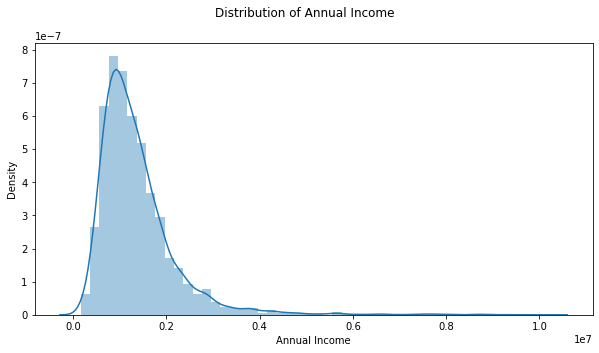

In [29]:
plt.figure(figsize = (10, 5))
sns.distplot(train['Annual Income'], bins=50)
plt.suptitle('Distribution of Annual Income')
plt.show()

In [30]:
ai_cols = [
 'Annual Income',
 'Credit Score',
 'CS2',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Current Loan Amount SUBS',
 'Maximum Open Credit MAXSUBS',
 'Maximum Open Credit MINSUBS',
 'Months since last delinquent SUBS',
 'Term MEAN Annual Income',
 'Home Ownership MEAN Annual Income',
 'Years in current job MEAN Annual Income',
 'Months since last delinquent CAT MEAN Annual Income',
 'Current Loan Amount CAT MEAN Annual Income',
 'Number of Credit Problems MEAN Annual Income'] + list(set(DUMMIES_COLS_AI))

In [31]:
#Удалем категориальные признаки, которые мы перевели в дамммис.
for col in CAT_COLS_AI:
    if col in ai_cols:
        ai_cols.remove(col)

In [32]:
X_ai = train[ai_cols].loc[~train['Annual Income'].isna()]
y_ai = train.loc[~train['Annual Income'].isna(), 'Annual Income']

In [33]:
X_ai = X_ai.drop(columns=['Annual Income'])
ai_cols.remove('Annual Income')

In [34]:
X_train_income, X_test_income, y_train_income, y_test_income = \
train_test_split(X_ai, y_ai, test_size=0.3, shuffle=True, random_state=42)

In [35]:
income_model = CatBoostRegressor(random_state=42)

In [36]:
params = {'n_estimators':[100, 110, 120, 130],
          'max_depth':[3, 4, 5]}

In [37]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [38]:
gs_ai = GridSearchCV(income_model, params, scoring='r2', cv=cv, n_jobs=-2)

In [39]:
%%time
gs_ai.fit(X_train_income, y_train_income, verbose=0)

CPU times: user 1.14 s, sys: 145 ms, total: 1.28 s
Wall time: 5.88 s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4adea69a00>,
             n_jobs=-2,
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [100, 110, 120, 130]},
             scoring='r2')

In [40]:
gs_ai.best_params_

{'max_depth': 5, 'n_estimators': 130}

In [41]:
income_model = CatBoostRegressor(max_depth=gs_ai.best_params_['max_depth'],
                                 n_estimators=gs_ai.best_params_['n_estimators'],
                                 random_state=42)

In [42]:
income_model.fit(X_train_income, y_train_income, verbose=0)

R2:	0.724
RMSE:	436134.841
MSE:	190213599228.135


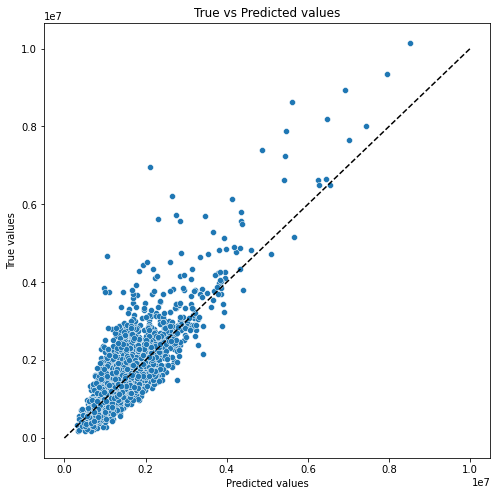

In [43]:
y_train_income_preds = income_model.predict(X_train_income)
evaluate_preds(y_train_income, y_train_income_preds)

R2:	0.562
RMSE:	581742.844
MSE:	338424736468.505


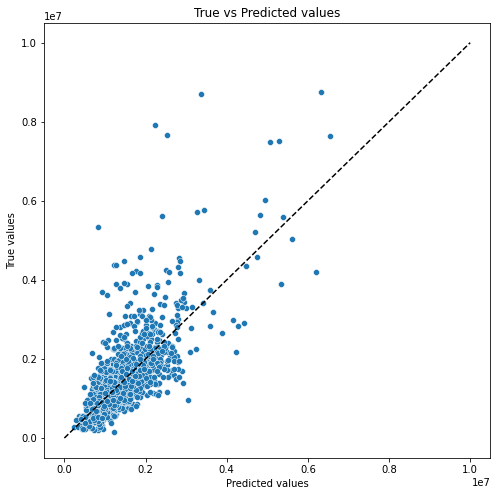

In [44]:
y_test_income_preds = income_model.predict(X_test_income)
evaluate_preds(y_test_income, y_test_income_preds)

In [45]:
income_importances = pd.DataFrame(zip(ai_cols, income_model.feature_importances_)).\
rename(columns={0: "Feature", 1: 'Importance'}).sort_values(by='Importance', ascending=False)
income_importances

,Feature,Importance
11,Monthly Debt,32.230456
9,Current Loan Amount,17.889027
12,Current Loan Amount SUBS,8.518708
4,Maximum Open Credit,5.165937
20,Current Loan Amount CAT MEAN Annual Income,4.555735
0,Credit Score,4.525406
1,CS2,3.473991
6,Months since last delinquent,3.339441
3,Number of Open Accounts,3.303235
17,Home Ownership MEAN Annual Income,3.271650


In [46]:
#Создание еще одной модели с меньшим количеством признаком, для уменьшения переобучения
income_columns = income_importances['Feature'][income_importances['Importance']>1].tolist()

In [47]:
income_short_model = CatBoostRegressor(max_depth=3,
                                       n_estimators=120,
                                       random_state=42)

In [48]:
income_short_model.fit(X_train_income[income_columns], y_train_income, verbose=0)

R2:	0.641
RMSE:	497424.494
MSE:	247431127501.732


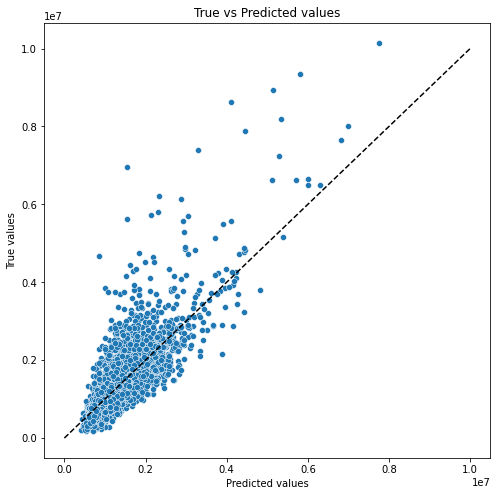

In [49]:
y_train_income_preds = income_short_model.predict(X_train_income[income_columns])
evaluate_preds(y_train_income, y_train_income_preds)

R2:	0.548
RMSE:	591504.513
MSE:	349877589032.92


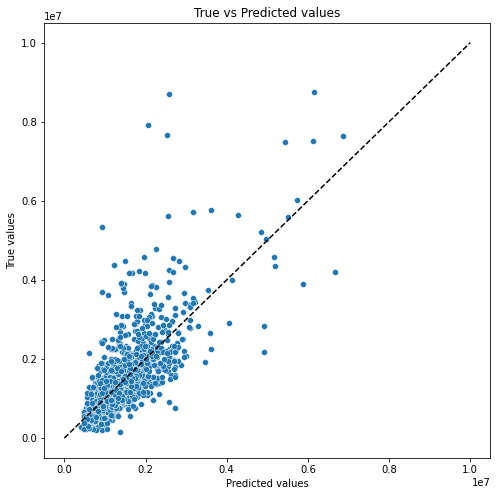

In [50]:
y_test_income_preds = income_short_model.predict(X_test_income[income_columns])
evaluate_preds(y_test_income, y_test_income_preds)

In [51]:
#Заполнение пропусков прогнозными данными
train.loc[train['Annual Income'].isna(), 'Annual Income'] =\
                        income_short_model.predict(train.loc[train['Annual Income'].isna(), income_columns])
test.loc[test['Annual Income'].isna(), 'Annual Income'] =\
                        income_short_model.predict(test.loc[test['Annual Income'].isna(), income_columns])

## EDA

In [52]:
atributes = ['Annual Income',
             'Maximum Open Credit',
             'Current Loan Amount',
             'Current Credit Balance',
             'Monthly Debt',
             'Credit Score']

array([[<AxesSubplot:xlabel='Annual Income', ylabel='Annual Income'>,
        <AxesSubplot:xlabel='Maximum Open Credit', ylabel='Annual Income'>,
        <AxesSubplot:xlabel='Current Loan Amount', ylabel='Annual Income'>,
        <AxesSubplot:xlabel='Current Credit Balance', ylabel='Annual Income'>,
        <AxesSubplot:xlabel='Monthly Debt', ylabel='Annual Income'>,
        <AxesSubplot:xlabel='Credit Score', ylabel='Annual Income'>],
       [<AxesSubplot:xlabel='Annual Income', ylabel='Maximum Open Credit'>,
        <AxesSubplot:xlabel='Maximum Open Credit', ylabel='Maximum Open Credit'>,
        <AxesSubplot:xlabel='Current Loan Amount', ylabel='Maximum Open Credit'>,
        <AxesSubplot:xlabel='Current Credit Balance', ylabel='Maximum Open Credit'>,
        <AxesSubplot:xlabel='Monthly Debt', ylabel='Maximum Open Credit'>,
        <AxesSubplot:xlabel='Credit Score', ylabel='Maximum Open Credit'>],
       [<AxesSubplot:xlabel='Annual Income', ylabel='Current Loan Amount'>,
        

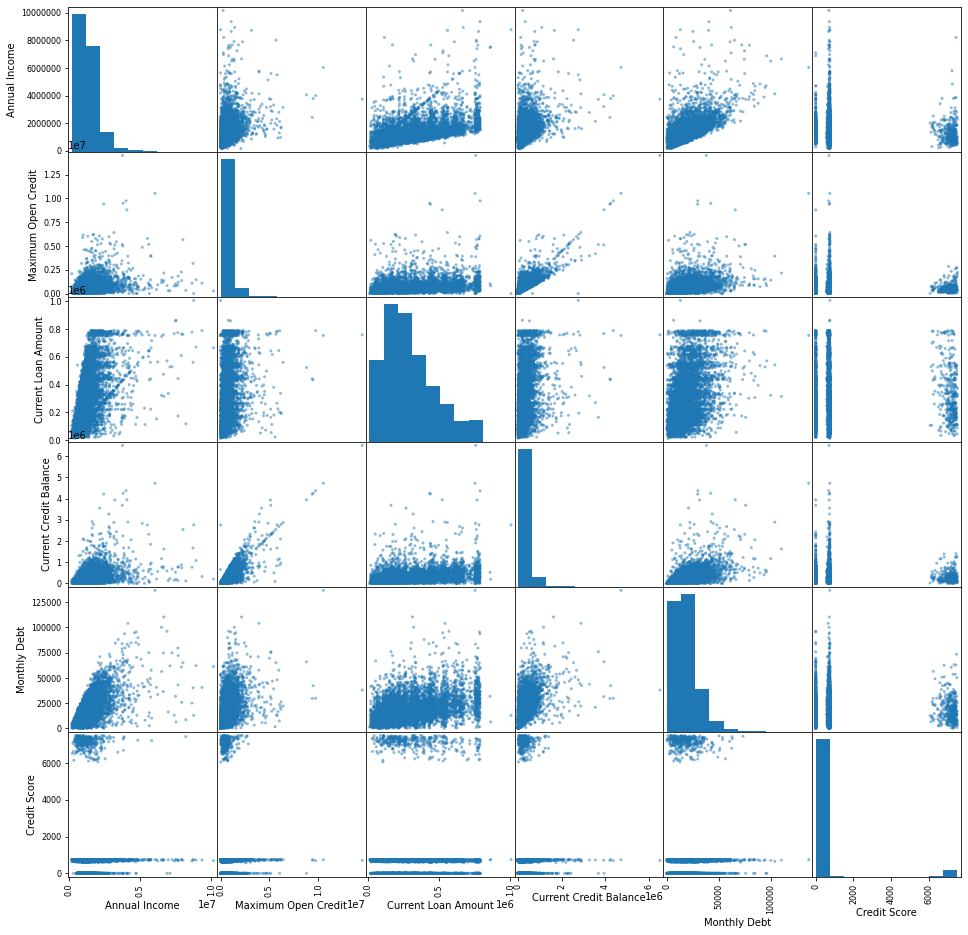

In [53]:
scatter_matrix(train[atributes], figsize=(16,16))
# plt.show()

In [54]:
cols = [
 'Annual Income',
 'Credit Score',
 'CS2',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Current Loan Amount SUBS',
 'Maximum Open Credit MAXSUBS',
 'Maximum Open Credit MINSUBS',
 'Months since last delinquent SUBS',
 'Term MEAN Annual Income',
 'Home Ownership MEAN Annual Income',
 'Years in current job MEAN Annual Income',
 'Months since last delinquent CAT MEAN Annual Income',
 'Current Loan Amount CAT MEAN Annual Income',
 'Number of Credit Problems MEAN Annual Income']

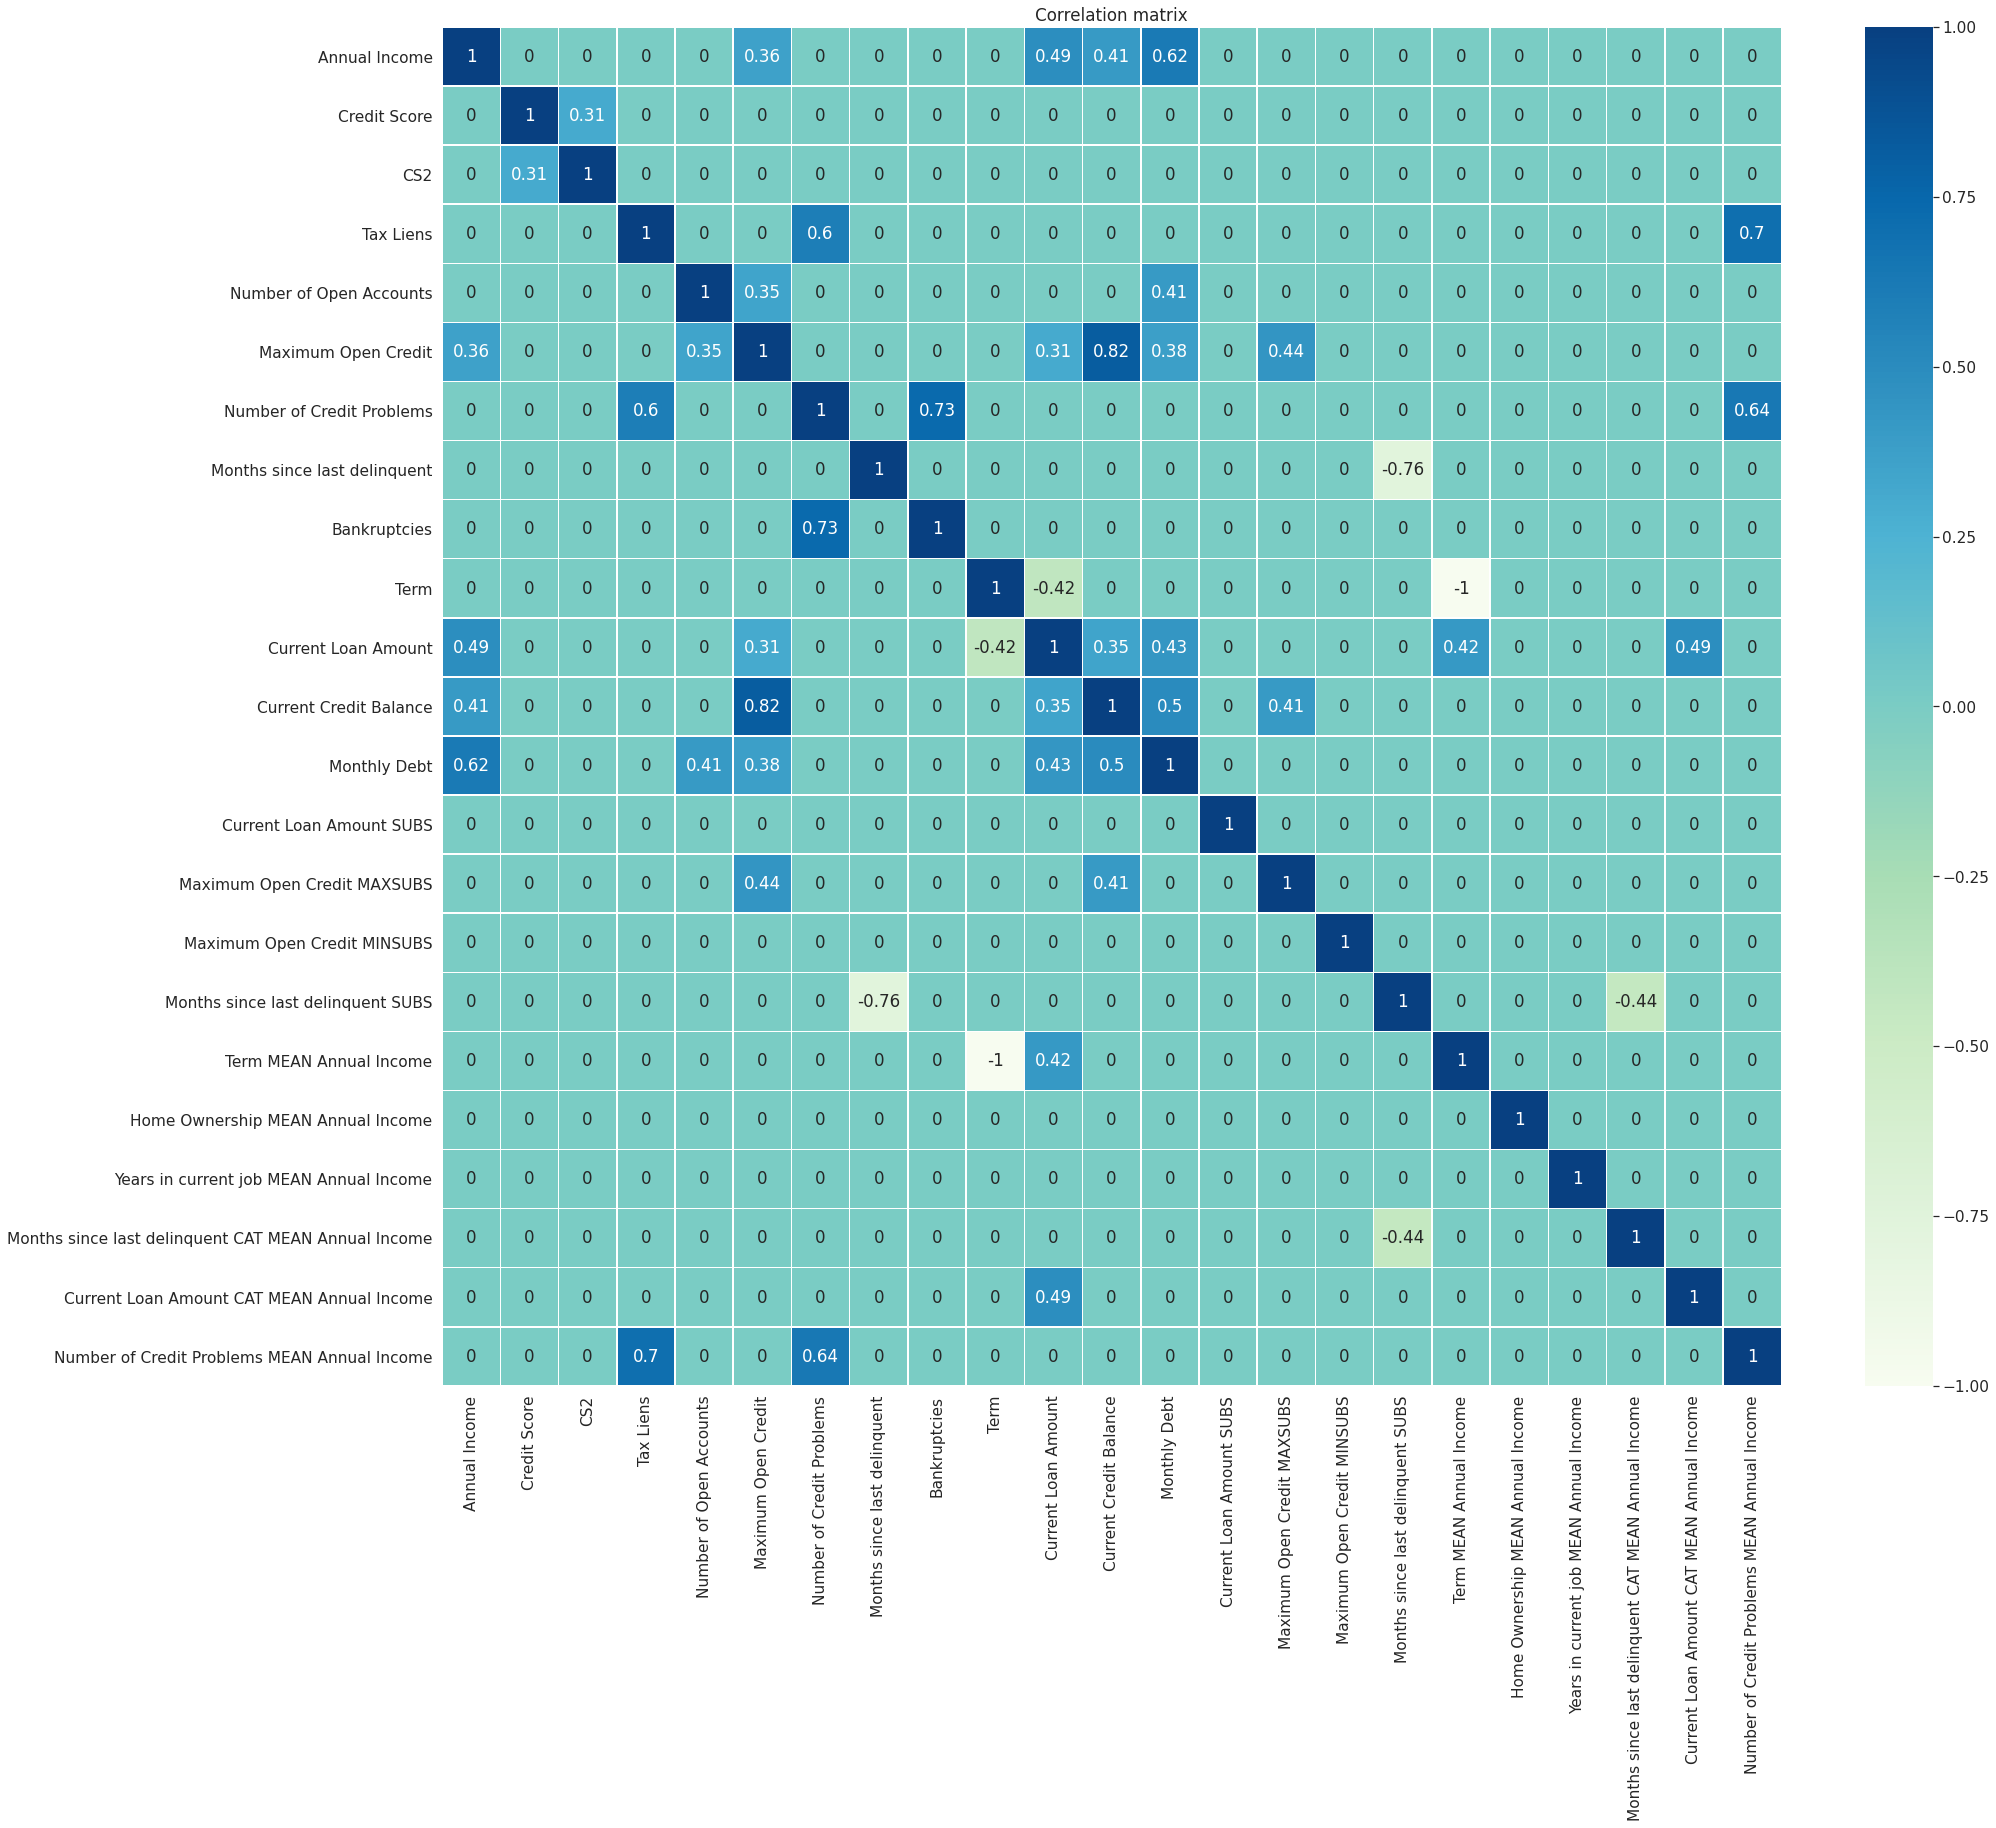

In [55]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.4)

corr_matrix = train[cols].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Создание новых и удаление ненужных признаков

In [56]:
#Создание признаков, в которых кодируем Credit Score для построения модели
for feature in TARGET_ENCODING_FEATURES:
    train, test = make_mean_encoding_smooth2(train, test, 'Credit Default', feature, alpha=2)

In [57]:
DUMMIES_COLS_CD = []
def create_dummies_CD(df):
    df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='HO')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Home Ownership'], prefix='HO').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Years in current job'], prefix='YCJ')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Years in current job'], prefix='YCJ').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Current Loan Amount CAT'], prefix='CLA')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Current Loan Amount CAT'], prefix='CLA').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Number of Open Accounts CAT'], prefix='NOOA')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Number of Open Accounts CAT'], prefix='NOOA').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Years of Credit History CAT'], prefix='YCH')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Years of Credit History CAT'], prefix='YCH').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Maximum Open Credit CAT'], prefix='MOC')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Maximum Open Credit CAT'], prefix='MOC').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Months since last delinquent CAT'], prefix='MSLD')], axis=1) 
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Months since last delinquent CAT'], prefix='MSLD').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='PRPS')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Purpose'], prefix='PRPS').columns[0])
    
    df = pd.concat([df, pd.get_dummies(df['Monthly Debt CAT'], prefix='MD')], axis=1)
    DUMMIES_COLS_AI.append(pd.get_dummies(df['Monthly Debt CAT'], prefix='MD').columns[0])
    
    return df

In [58]:
train = create_dummies_CD(train)
test = create_dummies_CD(test)

In [59]:
final_cols = train.columns.tolist()
final_cols.remove('Credit Default')
final_cols.remove('Id')
len(final_cols)

96

In [60]:
#Удаляем все признаки, которые не согласовываются на трейне и тесте по критерию МаннаУитни
final_cols_for_check = final_cols.copy()
for col in final_cols_for_check:
    if col in test:
        if mannwhitneyu(train[col], test[col]).pvalue<0.05:
            final_cols.remove(col)
    else:
        final_cols.remove(col)

In [61]:
#Удаляем категорияальные признаки, на основании которых были созданны даммис.
for col in CAT_COLS_AI+CAT_COLS:
    if col in final_cols:
        final_cols.remove(col)

In [62]:
len(final_cols)

60

Annual Income
MannwhitneyuResult(statistic=9328544.0, pvalue=0.3550858798852865)


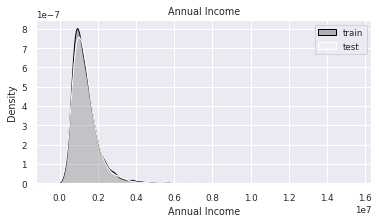

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


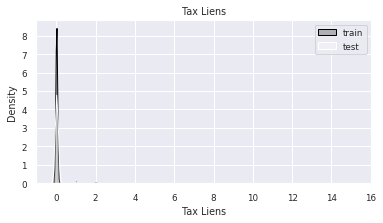

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


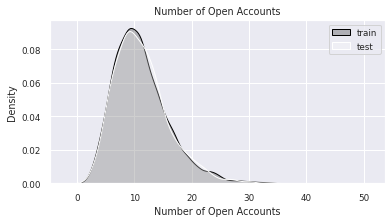

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


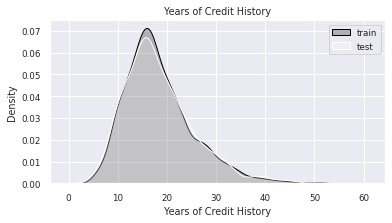

Maximum Open Credit
MannwhitneyuResult(statistic=9336863.0, pvalue=0.3801538204713352)


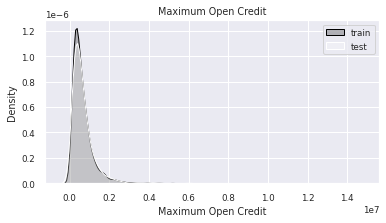

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


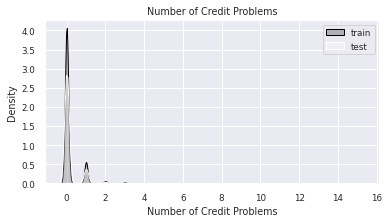

Months since last delinquent
MannwhitneyuResult(statistic=9346198.5, pvalue=0.40057108736095315)


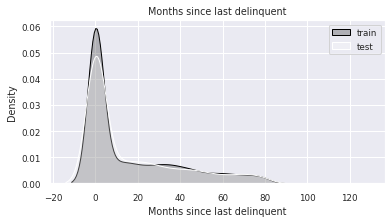

Current Loan Amount
MannwhitneyuResult(statistic=9293792.5, pvalue=0.25796771622287584)


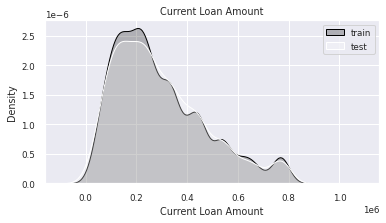

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


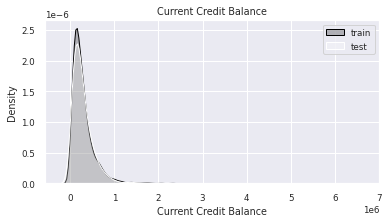

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


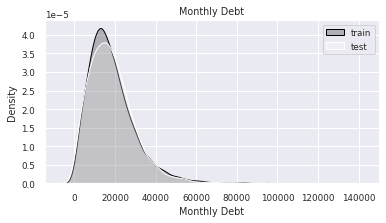

Credit Score
MannwhitneyuResult(statistic=9343647.0, pvalue=0.400541991002631)


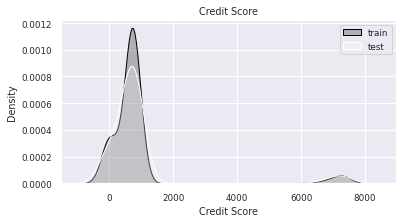

Current Loan Amount SUBS
MannwhitneyuResult(statistic=9348750.0, pvalue=0.35286157280000413)


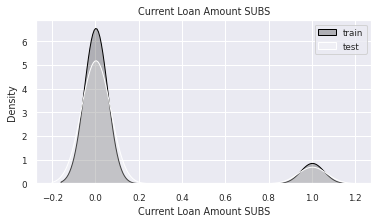

Maximum Open Credit MAXSUBS
MannwhitneyuResult(statistic=9368750.0, pvalue=0.3396738559957297)


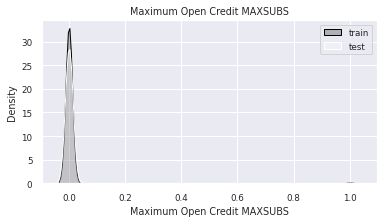

Maximum Open Credit MINSUBS
MannwhitneyuResult(statistic=9346250.0, pvalue=0.06682714920507397)


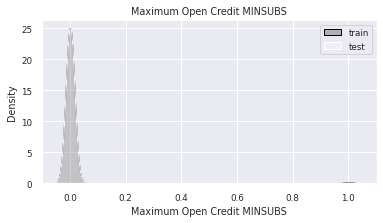

Months since last delinquent SUBS
MannwhitneyuResult(statistic=9366250.0, pvalue=0.4676678102791608)


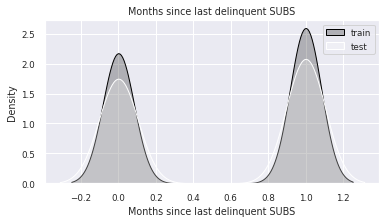

CS2
MannwhitneyuResult(statistic=9293855.5, pvalue=0.2571779105366478)


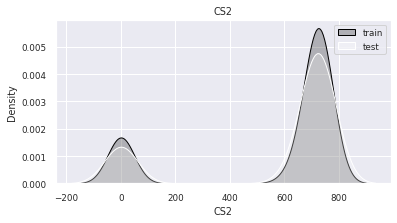

HO AI_Have Mortgage
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


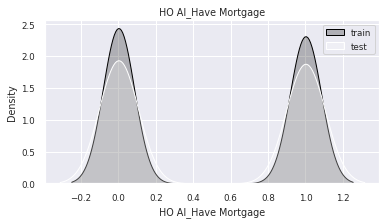

HO AI_Own Home
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


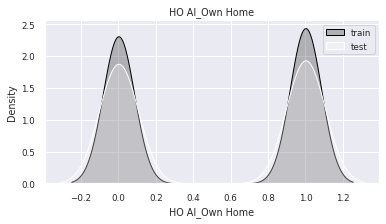

CLA AI_2
MannwhitneyuResult(statistic=9366250.0, pvalue=0.46364810458247874)


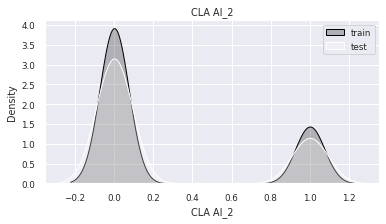

CLA AI_5
MannwhitneyuResult(statistic=9283750.0, pvalue=0.1864966917685678)


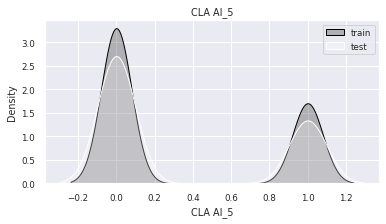

CLA AI_8
MannwhitneyuResult(statistic=9333750.0, pvalue=0.2647824821949355)


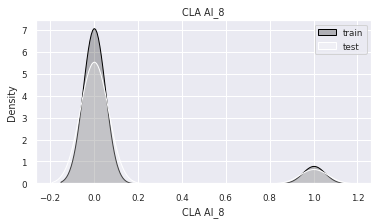

CLA AI_9
MannwhitneyuResult(statistic=9316250.0, pvalue=0.27527174609143534)


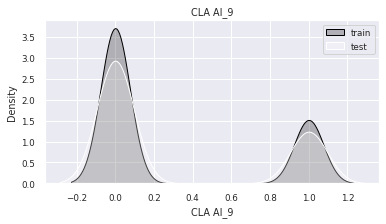

NOOA AI_7
MannwhitneyuResult(statistic=9366250.0, pvalue=0.46337553931309117)


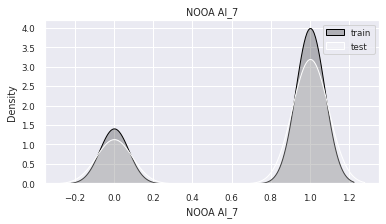

NOOA AI_10
MannwhitneyuResult(statistic=9370000.0, pvalue=0.47905020314589547)


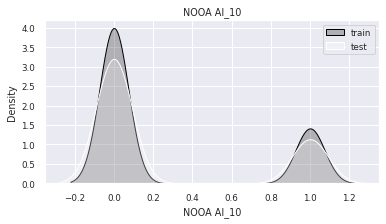

YCH AI_7
MannwhitneyuResult(statistic=9228750.0, pvalue=0.08833498942482854)


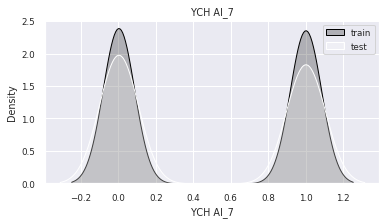

YCH AI_9
MannwhitneyuResult(statistic=9356250.0, pvalue=0.41450747004072946)


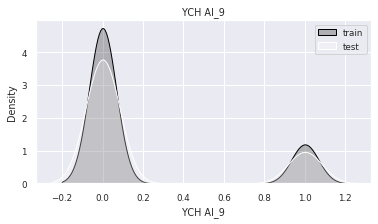

YCH AI_10
MannwhitneyuResult(statistic=9247500.0, pvalue=0.1006944815945709)


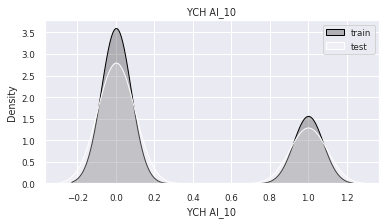

MOC AI_7
MannwhitneyuResult(statistic=9371250.0, pvalue=0.4849263155187791)


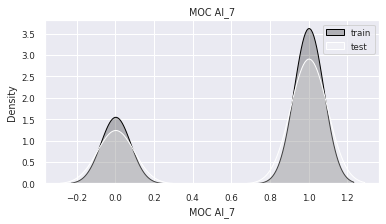

MOC AI_9
MannwhitneyuResult(statistic=9303750.0, pvalue=0.20450611309441807)


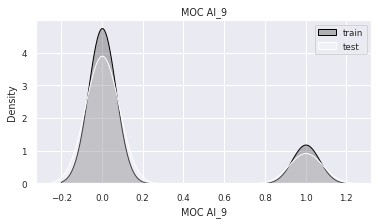

MOC AI_10
MannwhitneyuResult(statistic=9307500.0, pvalue=0.15127646602270328)


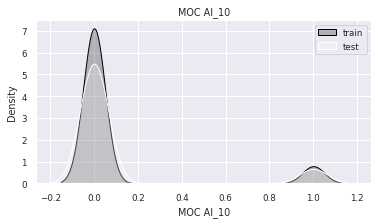

MSLD AI_7
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


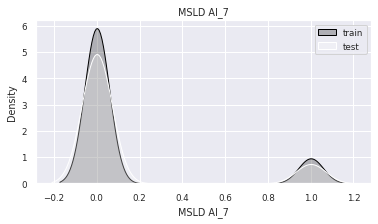

MSLD AI_10
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


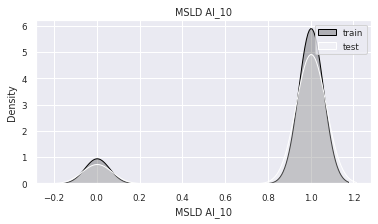

Term MEAN Annual Income
MannwhitneyuResult(statistic=9341250.0, pvalue=0.3608746500516738)


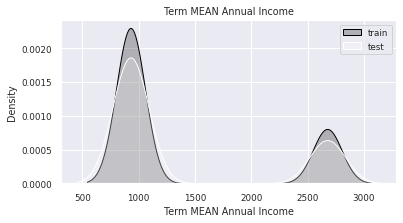

Home Ownership MEAN Annual Income
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


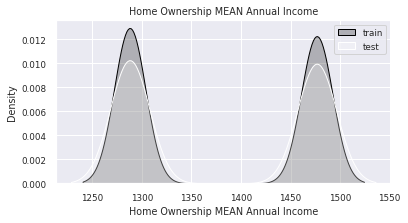

Months since last delinquent CAT MEAN Annual Income
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


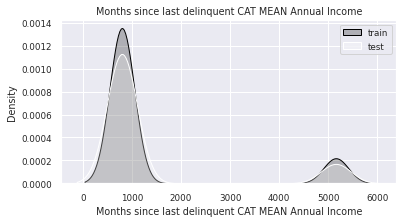

Years of Credit History CAT MEAN Annual Income
MannwhitneyuResult(statistic=9248674.5, pvalue=0.1356234350378186)


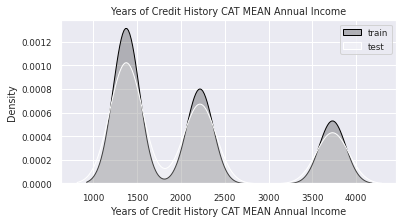

Current Loan Amount CAT MEAN Annual Income
MannwhitneyuResult(statistic=9247490.0, pvalue=0.14329467339719648)


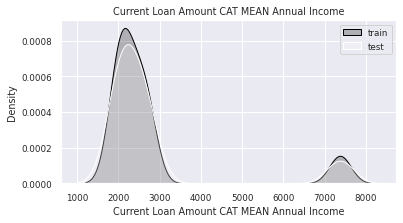

Number of Credit Problems MEAN Annual Income
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


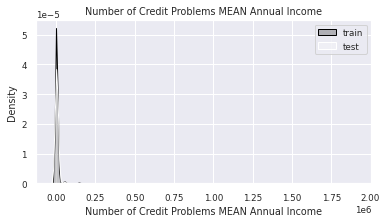

Term MEAN Credit Default
MannwhitneyuResult(statistic=9341250.0, pvalue=0.3608746500516738)


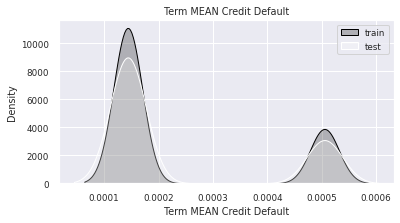

No handles with labels found to put in legend.


Home Ownership MEAN Credit Default
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


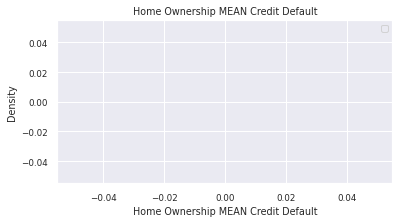

Months since last delinquent CAT MEAN Credit Default
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


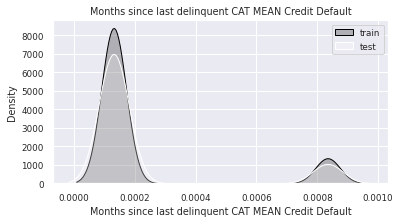

Years of Credit History CAT MEAN Credit Default
MannwhitneyuResult(statistic=9248674.5, pvalue=0.1356234350378186)


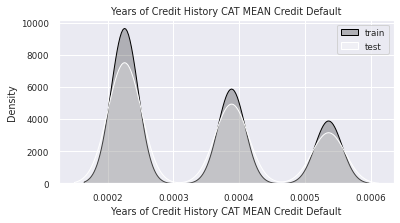

Current Loan Amount CAT MEAN Credit Default
MannwhitneyuResult(statistic=9247490.0, pvalue=0.14329467339719648)


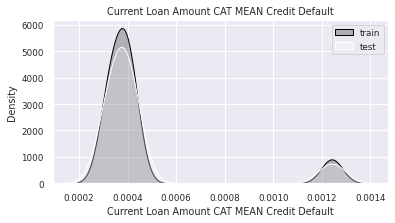

Number of Credit Problems MEAN Credit Default
MannwhitneyuResult(statistic=9295533.5, pvalue=0.14201831413753302)


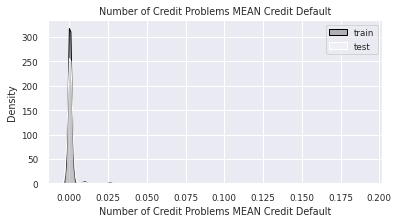

HO_Have Mortgage
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


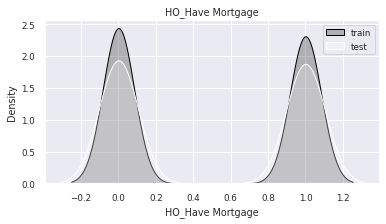

HO_Own Home
MannwhitneyuResult(statistic=9316250.0, pvalue=0.29362299375699974)


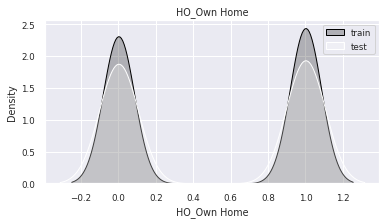

CLA_2
MannwhitneyuResult(statistic=9366250.0, pvalue=0.46364810458247874)


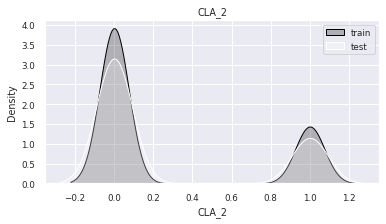

CLA_5
MannwhitneyuResult(statistic=9283750.0, pvalue=0.1864966917685678)


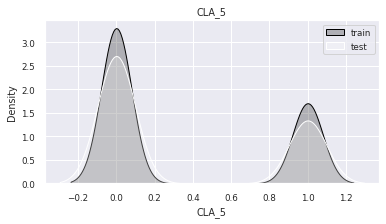

CLA_8
MannwhitneyuResult(statistic=9333750.0, pvalue=0.2647824821949355)


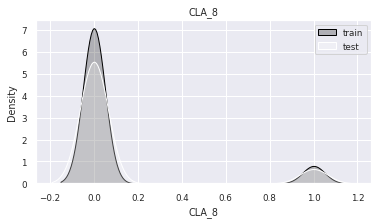

CLA_9
MannwhitneyuResult(statistic=9316250.0, pvalue=0.27527174609143534)


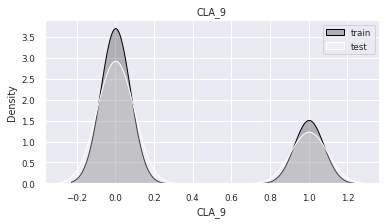

NOOA_7
MannwhitneyuResult(statistic=9366250.0, pvalue=0.46337553931309117)


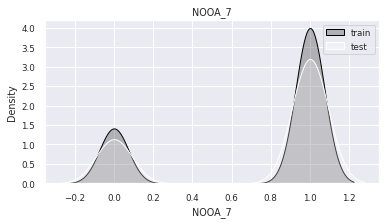

NOOA_10
MannwhitneyuResult(statistic=9370000.0, pvalue=0.47905020314589547)


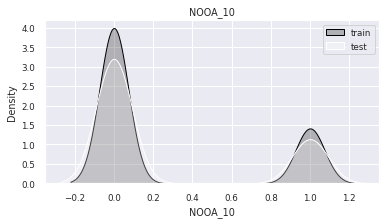

YCH_7
MannwhitneyuResult(statistic=9228750.0, pvalue=0.08833498942482854)


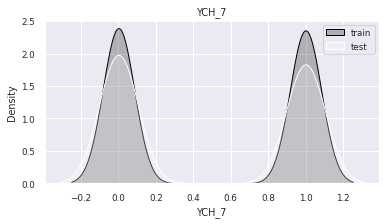

YCH_9
MannwhitneyuResult(statistic=9356250.0, pvalue=0.41450747004072946)


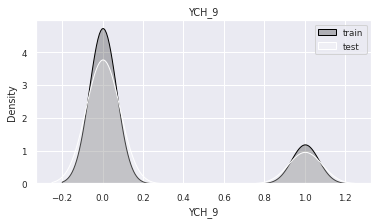

YCH_10
MannwhitneyuResult(statistic=9247500.0, pvalue=0.1006944815945709)


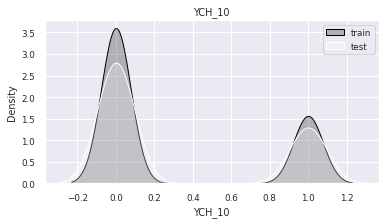

MOC_7
MannwhitneyuResult(statistic=9371250.0, pvalue=0.4849263155187791)


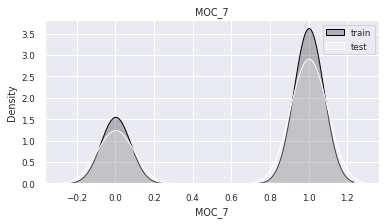

MOC_9
MannwhitneyuResult(statistic=9303750.0, pvalue=0.20450611309441807)


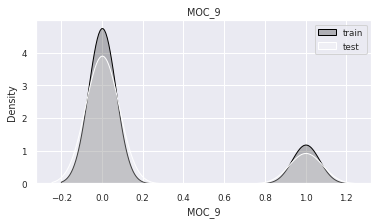

MOC_10
MannwhitneyuResult(statistic=9307500.0, pvalue=0.15127646602270328)


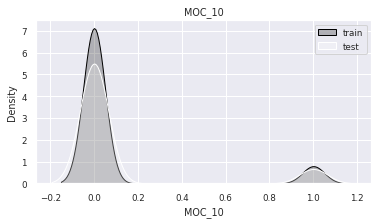

MSLD_7
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


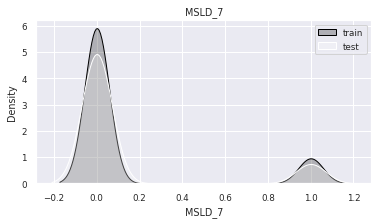

MSLD_10
MannwhitneyuResult(statistic=9293750.0, pvalue=0.1374865001347182)


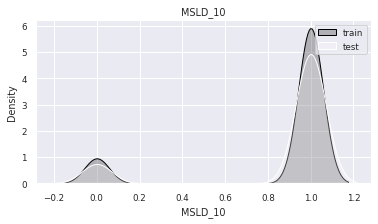

In [63]:
figsize = (6, 3)
for col in final_cols:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='black')
    sns.kdeplot(test[col], shade=True, label='test', color='white')
    print(col)
    print(mannwhitneyu(train[col], test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

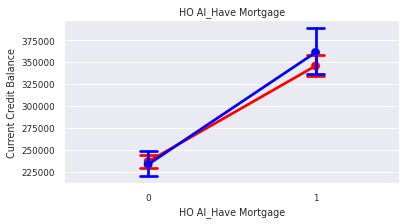

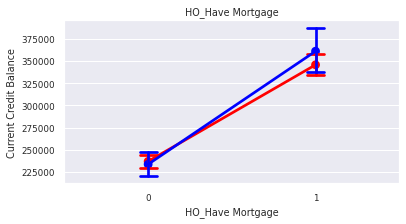

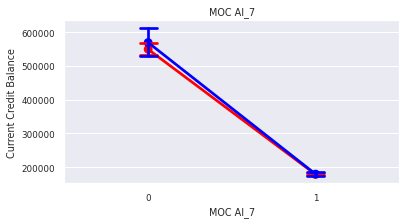

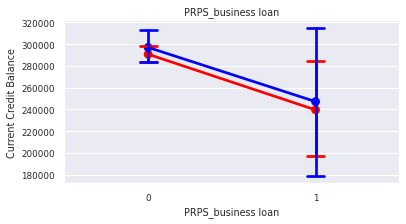

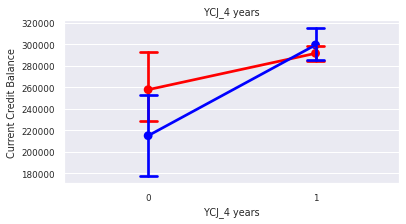

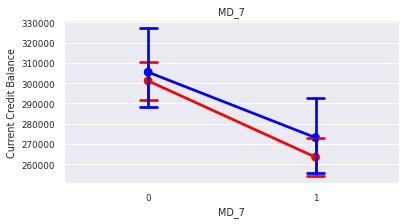

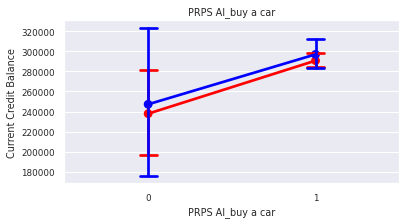

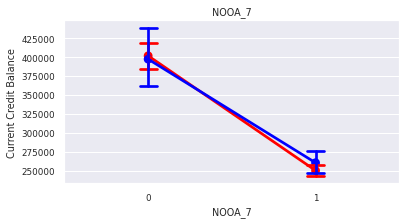

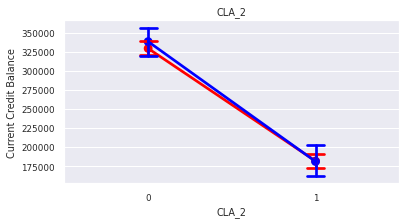

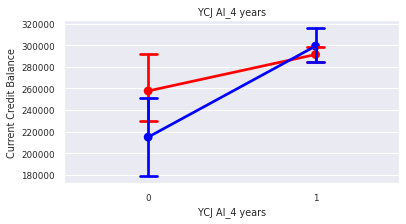

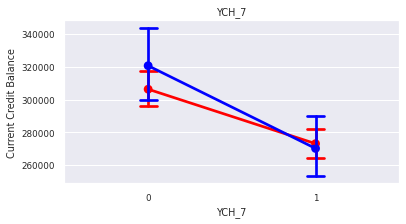

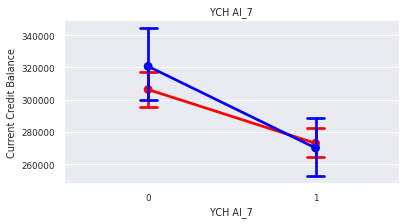

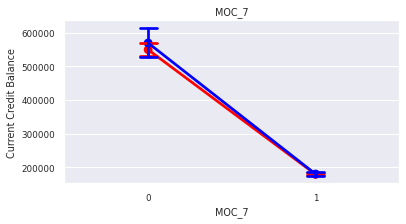

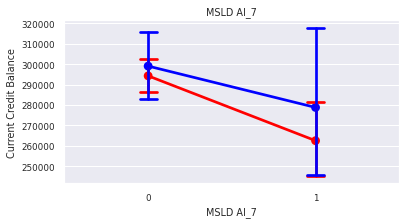

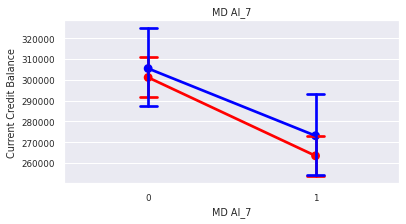

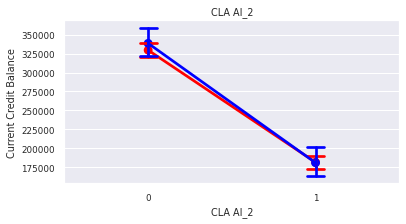

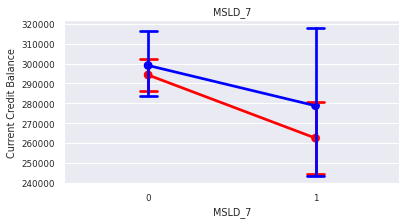

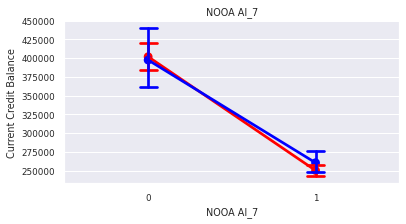

In [64]:
#Проврка распределений признаков на трейне и тесте
num_feature = 'Current Credit Balance'
for col in list(set(DUMMIES_COLS_CD))+list(set(DUMMIES_COLS_AI)):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='red')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='blue')
    plt.title(col) 
    plt.show()

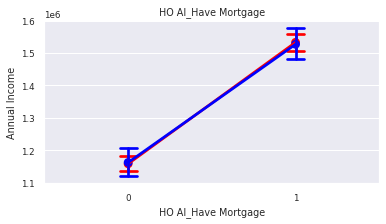

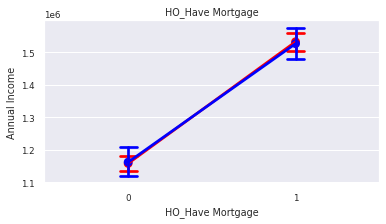

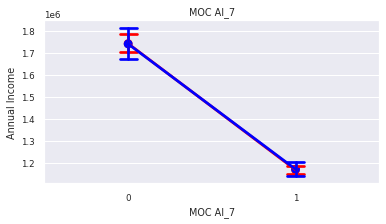

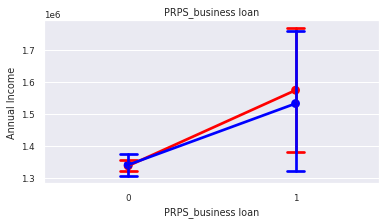

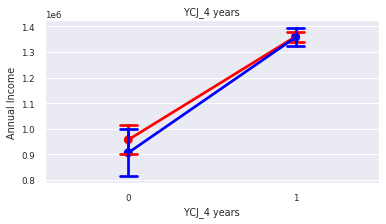

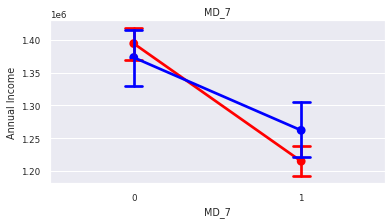

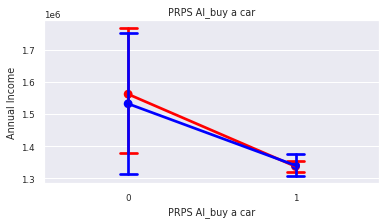

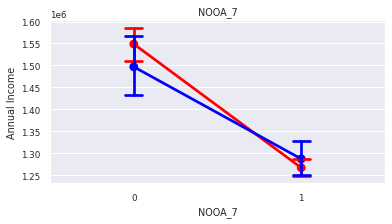

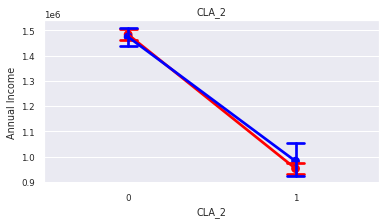

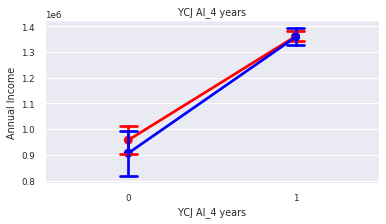

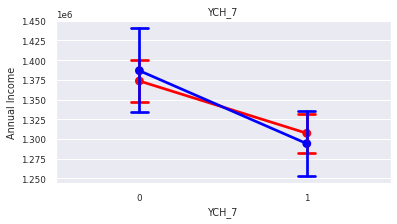

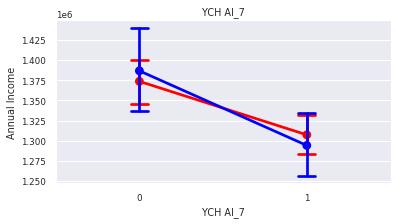

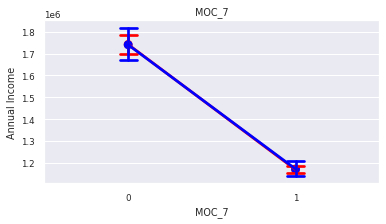

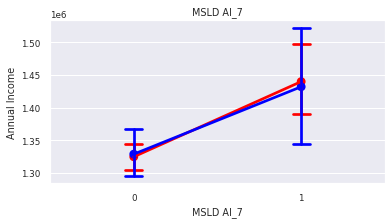

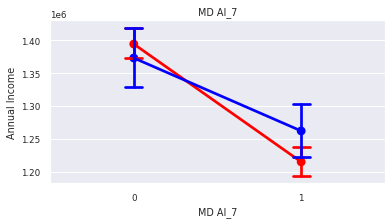

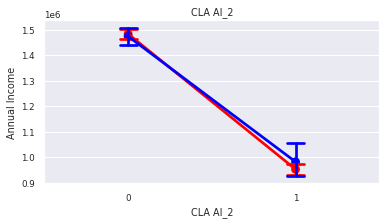

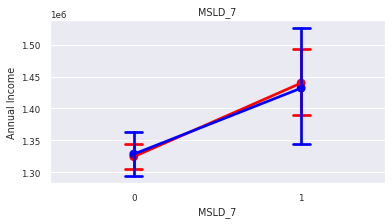

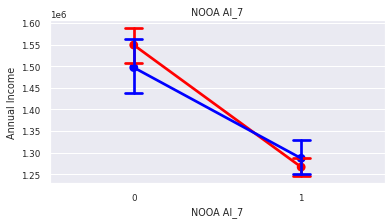

In [65]:
num_feature = 'Annual Income'
for col in list(set(DUMMIES_COLS_CD))+list(set(DUMMIES_COLS_AI)):
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='red')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='blue')
    plt.title(col) 
    plt.show()

In [66]:
COLS_FOR_EXCLUSION = ['Years in current job', 'Years in current job AI', 'MSLD_7']
MAYBE_COLS_FOR_EXCLUSION = ['MSLD AI_7']

In [67]:
for col in COLS_FOR_EXCLUSION + MAYBE_COLS_FOR_EXCLUSION:
    if col in final_cols:
        final_cols.remove(col)

In [68]:
final_cols

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Current Loan Amount SUBS',
 'Maximum Open Credit MAXSUBS',
 'Maximum Open Credit MINSUBS',
 'Months since last delinquent SUBS',
 'CS2',
 'HO AI_Have Mortgage',
 'HO AI_Own Home',
 'CLA AI_2',
 'CLA AI_5',
 'CLA AI_8',
 'CLA AI_9',
 'NOOA AI_7',
 'NOOA AI_10',
 'YCH AI_7',
 'YCH AI_9',
 'YCH AI_10',
 'MOC AI_7',
 'MOC AI_9',
 'MOC AI_10',
 'MSLD AI_10',
 'Term MEAN Annual Income',
 'Home Ownership MEAN Annual Income',
 'Months since last delinquent CAT MEAN Annual Income',
 'Years of Credit History CAT MEAN Annual Income',
 'Current Loan Amount CAT MEAN Annual Income',
 'Number of Credit Problems MEAN Annual Income',
 'Term MEAN Credit Default',
 'Home Ownership MEAN Credit Default',
 'Months since last delinquent CAT MEAN Credi

## Поиск наилучшей модели

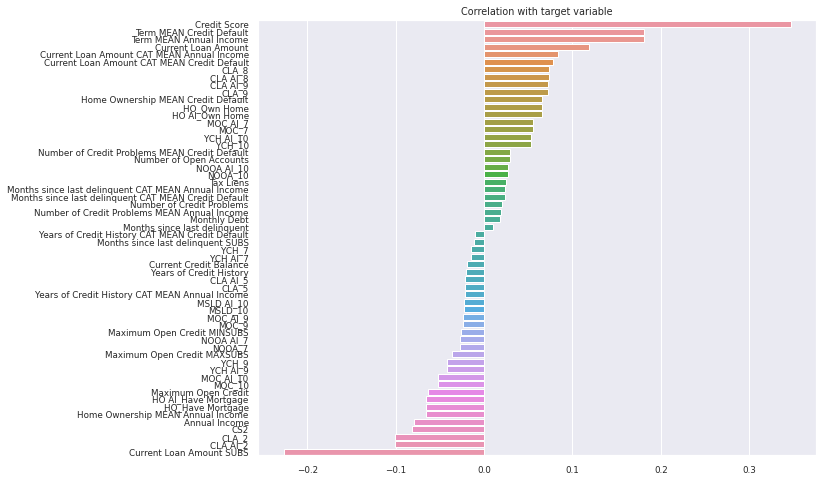

In [69]:
corr_with_target = train[final_cols + TARGET].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [70]:
#Нужно проследить, что params работает правильно, если мы не используем gridsearch.
"""
Порядок работы с классом:
1. С или без признака Credit Score.
Вначале формируется модель на всех признаках и на всех признаках кроме Credit Score c последующей прямой
подстановкой единиц в итоговое решение для тех наблюдений, где Credit Score равен 1 (или больше 3000, если не
обрабатывать класс). Подстановку делаем в обоих вариантах.

ModelSearch: balance_mode=None, CS_data_sep=False.
create_model: best_feat=False, gr_features=None, must=[], gs=True, params=None, cv=None,
              threshold_fit=False, topN=5, CS_subs=True
Модели формируем два раза - threshold_fit==False и ==True (подбор оптимальной отсечки).

2. С или без наблюдений, у которых Credit Score == 1 (больше 3000 при необработанном классе)
Проверяем качество модели при разных значениях CS_data_sep (учитываем или не учитываем наблюдения, в
которых Credit Score равен 1 (больше 3000 при необработанных данных) при обучении модели).

3. Подбор признаков.
От предыдущией лучше модели берем все признаки со значимостью более 1%.
Берем топ-7 признаков и все возможные их комбинации. Проверяем на какой комбинации модель будет лучше всего
работать. Добавляем лучшую комбинацию в must (эти признаки точно будут учавствовать). Оставшиеся признаки
разбиваем максимум на 7 групп и вместе с must определяем лучшую модель.
Фиксируем получаенные признаки в параметре final_cols.

4. Балансировка.
Проверяем качество модели при следующих вариантах балансировок:
- tomek
- smote
- вначале tomek, а потом smote
Выбираем лучшую модель.

5. Поиск параметров модели.
Изначально указываем по три значения для каждого параметра модели. Значения параметров должны значительно
отличаться друг от друга. Находим параметры с наилучшими показателями, оставляем их. Придвигаем оставшиеся
варианты параметров к уже найденным. Делаем так, пока разница между параметрами не будет минимальной.
"""

class ModelSearch:
    def __init__(self, model_name, df, cols, target, balance_mode=None, CS_data_sep=False):
        self.best_features = None
        
        self.model_name = model_name
        self.df = df
        self.cols = cols
        self.target = target
        self.balance_mode=balance_mode
        self.CS_data_sep = CS_data_sep
        
        self.best_feat = None
        self.gr_features = None
        self.must = None
        self.gs=None
        self.params = None
        self.cv = None
        self.threshold_fit = None
        self.topN = None
        self.CS_subs = None
        self.best_params = pd.DataFrame(columns=['Model', 'Features', 'Best params'])
        self.i_for_bp = 0
        self.model = None
        self.threshold = None
        self.total = pd.DataFrame(columns=['Name',
                                           'Params',
                                           'Features',
                                           'F1 train',
                                           'F1 test',
                                           'Overfitting'])
        self.total.loc[0] = 0
        
        self.X_train = None
        self.y_train = None
        self.X_train_balanced = None
        self.y_train_balanced = None
        self.X_test = None
        self.y_test = None
        self.y_test_pred = None
        self.y_train_pred = None
          
        if 'Credit Score' in cols:
            self.X_train = df[self.cols]
            self.y_train = df[self.target]
        else:
            self.X_train = df[self.cols+['Credit Score']]
            self.y_train = df[self.target]
      
        
        self.X_train_full, self.X_test, self.y_train_full, self.y_test = train_test_split(self.X_train,
                                                                                          self.y_train,
                                                       shuffle=True, test_size=0.25, random_state=42,
                                                    stratify=self.y_train)
        
        #Если CS_data_sep равна True, то в постороении модели не учитываем наблюдения, где 'Credit Score'==1
        if CS_data_sep:
            self.X_train = pd.DataFrame(self.X_train_full)
            self.y_train = pd.DataFrame(self.y_train_full)
            self.X_train = self.X_train.loc[self.X_train_full['Credit Score']==0, self.cols]
            self.y_train = self.y_train.loc[self.X_train_full['Credit Score']==0]
        else:
            self.X_train = pd.DataFrame(self.X_train_full)
            self.y_train = pd.DataFrame(self.y_train_full)
            
        if balance_mode!=None:
            self.df_for_balancing = pd.concat([self.X_train, self.y_train], axis=1)
            self.df_balanced = balance_df_by_target(self.df_for_balancing, self.target, method=balance_mode)
            #Можно еще сделать двойнную балансировку классов
            self.X_train_balanced = self.df_balanced.drop(columns=target)
            self.y_train_balanced = self.df_balanced[target]
        else:
            self.X_train_balanced = self.X_train
            self.y_train_balanced = self.y_train
    

    def determine_best_features(self, features, X_train, y_train, X_test, y_test, must=[]):
        model = self.model
        result = pd.DataFrame(columns=['F1 train', 'F1 test', 'Overfitting', 'Features'])
        result.loc[0] = 0


        options = []
        for L in range(0, len(features)+1):
            for subset in itertools.combinations(features, L):
                if len(subset)>0:
                    options.append(list(itertools.chain(*subset))+must)
    
        iterations = len(options)
        i = 0
        for opt in options:
            if self.model_name!='GB':
                model.fit(X_train[opt], y_train, verbose=0)
            else:
                model.fit(X_train[opt], y_train)
            i += 1
            print(f'Iteration {i} of {iterations}, '+  '{:.1%}'.format(i/iterations), end="\r")
            y_train_pred = model.predict(X_train[opt])
            y_test_pred = model.predict(X_test[opt])
            result.loc[result.index.max()+1] = [f1(y_train, y_train_pred, average='binary'),
                                                      f1(y_test, y_test_pred, average='binary'),
                                                      f1(y_train, y_train_pred, average='binary') -\
                                                      f1(y_test, y_test_pred, average='binary'),
                                                      opt]

        result = result.drop([0])
        result['Sorting'] = result['F1 test'] - result['Overfitting']


        return result.sort_values(by='F1 test', ascending=False)
   


    def best_threshold(self, y_predicted_probs, y_true_labels):
        preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

        thresholds = []
        f1_scores = []

        for threshold in np.linspace(0.05, 0.95, 18):
            thresholds.append(threshold)
            f1_scores.append(f1(y_true_labels, list(map(int, y_predicted_probs > threshold)),
                                average='binary'))

        scores_table = pd.DataFrame({'f1':f1_scores,
                                     'probability':thresholds}).sort_values('f1', ascending=False).round(3)
        return scores_table.iloc[0, 1]
    

    
    def create_model(self, best_feat=True, gr_features=None, must=[], gs=True, params=None, cv=None,
              threshold_fit=True, topN=3, CS_subs=True):
        
        self.best_feat = best_feat
        self.gr_features = gr_features
        self.must = must
        self.gs = gs
        self.threshold_fit = threshold_fit
        self.topN = topN
        self.CS_subs = CS_subs
        
        if cv == None:
            self.cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        else:
            self.cv = cv
        
        if self.model_name == 'CB':
            self.model = CatBoostClassifier(max_depth=3, n_estimators=50, random_state=42)
            if params!=None:
                self.params = params
            else:
                self.params = {'n_estimators':[30, 100, 200], 'max_depth':[3, 5, 7]}
        
        elif self.model_name =='XGB':
            self.model = xgb.XGBClassifier(max_depth=3, n_estimators=50, gamma=0.5, random_state=42)
            if params!=None:
                self.params = params
            else:
                self.params = {'n_estimators':[50, 100, 150, 300, 600], 'max_depth':[3, 7, 10, 15]}
        
        elif self.model_name== 'LGBM':
            self.model = lgbm.LGBMClassifier(max_depth=3, n_estimators=50, reg_lambda=0.5, random_state=42)
            if params!=None:
                self.params = params
            else:
                self.params = {'n_estimators':[20, 30, 50], 'max_depth':[3], 'reg_lambda': [0.5, 0.9]}
        
        elif self.model_name == 'GB':
            self.model = GradientBoostingClassifier(max_depth=3, n_estimators=400)
            if params!=None:
                self.params = params
            else:
                self.params = {'n_estimators':[100, 200, 400], 'max_depth':[3, 7, 15]}
            

        if best_feat:
            self.best_features = self.determine_best_features(
                                                     gr_features,
                                                     self.X_train_balanced,
                                                     self.y_train_balanced, self.X_test, self.y_test,
                                                     must=must).head(topN)['Features'].tolist()
        else:
            self.best_features = self.cols
   
    
        if gs:
            for feats in self.best_features:
                grid_search = GridSearchCV(self.model, self.params, cv=self.cv, scoring='f1',
                                           n_jobs=-1, verbose=0)
                if self.model_name!='GB':
                    grid_search.fit(self.X_train_balanced[feats], self.y_train_balanced, verbose=0)
                else:
                    grid_search.fit(self.X_train_balanced[feats], self.y_train_balanced)
                
                self.best_params.loc[self.i_for_bp + 1] = [self.model_name, feats, grid_search.best_params_]
                self.i_for_bp += 1
                if self.model_name == 'CB':
                    self.model = CatBoostClassifier(max_depth=grid_search.best_params_['max_depth'],
                                                   n_estimators=grid_search.best_params_['n_estimators'],
                                                    random_state=42)
                elif self.model_name =='XGB':
                    self.model = xgb.XGBClassifier(max_depth=grid_search.best_params_['max_depth'],
                                                   n_estimators=grid_search.best_params_['n_estimators'],
                                                   gamma=0.5,
                                                   random_state=42)
                elif self.model_name == 'LGBM':
                    self.model = lgbm.LGBMClassifier(max_depth=grid_search.best_params_['max_depth'],
                                                     n_estimators=grid_search.best_params_['n_estimators'],
                                                     reg_lambda=grid_search.best_params_['reg_lambda'],
                                                     random_state=42)
                elif self.model_name == 'GB':
                    self.model = GradientBoostingClassifier(max_depth=grid_search.best_params_['max_depth'],
                                                            n_estimators=\
                                                            grid_search.best_params_['n_estimators'],
                                                            random_state=42)
#                 if self.model_name == 'CB':
#                     train_data = np.array(pd.concat([self.X_train_balanced[feats], self.y_train_balanced],
#                                                     axis=0))
#                     eval_data = np.array(pd.concat([self.X_test[feats], self.y_test], axis=0))
                    
#                     train_label = np.ones(len(pd.concat([self.X_train_balanced[feats], self.y_train_balanced],
#                                                     axis=0)))
#                     train_labels[-1] = 0
#                     eval_label = np.zeros(len(pd.concat([self.X_test[feats], self.y_test], axis=0)))
#                     eval_label[-1] = 1
#                     train_dataset = Pool(data=train_data, label=train_label)
#                     eval_dataset = Pool(data=eval_data, label=eval_label)
                                                         
#                     self.model.fit(train_dataset,
#                                    use_best_model=True,
#                                    eval_set=eval_dataset)
                if self.model_name!='GB':
                    self.model.fit(self.X_train_balanced[feats], self.y_train_balanced, verbose=0)
                else:
                    self.model.fit(self.X_train_balanced[feats], self.y_train_balanced)
                
                if threshold_fit:
                    #Находим вероятности для главного класса
                    y_train_pred_probs = self.model.predict_proba(self.X_train_full[feats])
                    y_test_pred_probs = self.model.predict_proba(self.X_test[feats])

                    #Определяем лучшую отсечку
                    threshold_model_train = self.best_threshold(y_train_pred_probs[:, 1], self.y_train_full)
                    threshold_model_test = self.best_threshold(y_test_pred_probs[:, 1], self.y_test)
                    self.threshold = threshold_model_train

                    #Корректируем итоговый результат с учетом лучшей отсечки
                    y_train_pred = (y_train_pred_probs[:,1] > self.threshold)
                    y_test_pred = (y_test_pred_probs[:,1] > self.threshold)
                else:
                    y_train_pred = self.model.predict(self.X_train_full[feats])
                    y_test_pred = self.model.predict(self.X_test[feats])
                    y_train_pred = np.where(y_train_pred==0, False, True)
                    y_test_pred = np.where(y_test_pred==0, False, True)
                    
                              
                if CS_subs:
                    y_train_pred = pd.DataFrame(y_train_pred)
                    y_train_pred.iloc[self.X_train_full['Credit Score']>3000] = True
                    y_train_pred = np.array(y_train_pred[0])

                    y_test_pred = pd.DataFrame(y_test_pred)
                    y_test_pred.iloc[self.X_test['Credit Score']>3000] = True
                    y_test_pred = np.array(y_test_pred[0])
                    self.y_test_pred = y_test_pred
                    self.y_train_pred = y_train_pred 
                else:
                    y_train_pred = self.model.predict(self.X_train_full[feats])
                    y_test_pred = self.model.predict(self.X_test[feats])
                    self.y_test_pred = y_test_pred
                    self.y_train_pred = y_train_pred 
    
                self.total.loc[self.total.index.max()+1] = [self.model_name,
                                                       grid_search.best_params_,
                                                       feats,
                                                       f1(self.y_train_full, y_train_pred, average='binary'),
                                                       f1(self.y_test, y_test_pred, average='binary'),
                                                       f1(self.y_train_full, y_train_pred, average='binary')-\
                                                       f1(self.y_test, y_test_pred, average='binary')]
        else:
#             if self.model_name == 'CB':
#                 train_data = np.array(pd.concat([self.X_train_balanced[self.best_features],
#                                                  self.y_train_balanced], axis=0))
#                 eval_data = np.array(pd.concat([self.X_test[self.best_features], self.y_test], axis=0))

#                 train_label = np.ones(len(pd.concat([self.X_train_balanced[self.best_features],
#                                                      self.y_train_balanced], axis=0)))
#                 train_label[-1] = 0
#                 eval_label = np.zeros(len(pd.concat([self.X_test[self.best_features], self.y_test], axis=0)))
#                 eval_label[-1] = 1
#                 train_dataset = Pool(data=train_data, label=train_label)
#                 eval_dataset = Pool(data=eval_data, label=eval_label)

#                 self.model.fit(train_dataset,
#                                use_best_model=True,
#                                eval_set=eval_dataset)
# 
            if self.model_name!='GB':
                self.model.fit(self.X_train_balanced[self.best_features], self.y_train_balanced, verbose=0)
            else:
                self.model.fit(self.X_train_balanced[self.best_features], self.y_train_balanced)
                
            if threshold_fit:
                #Находим вероятности для главного класса
                y_train_pred_probs = self.model.predict_proba(self.X_train_full[self.cols])
                y_test_pred_probs = self.model.predict_proba(self.X_test[self.cols])
               
                #Определяем лучшую отсечку
                threshold_model_train = self.best_threshold(y_train_pred_probs[:, 1], self.y_train_full)
                threshold_model_test = self.best_threshold(y_test_pred_probs[:, 1], self.y_test)
                self.threshold = threshold_model_train

                #Корректируем итоговый результат с учетом лучшей отсечки
                y_test_pred = (y_test_pred_probs[:,1] > self.threshold)
                y_train_pred = (y_train_pred_probs[:,1] > self.threshold)
                self.y_test_pred = y_test_pred
                self.y_train_pred = y_train_pred
            else:
                y_train_pred = self.model.predict(self.X_train_full[self.cols])
                y_test_pred = self.model.predict(self.X_test[self.cols])
                y_train_pred = np.where(y_train_pred==0, False, True)
                y_test_pred = np.where(y_test_pred==0, False, True)
                
            if CS_subs:
                y_train_pred = pd.DataFrame(y_train_pred)
                y_train_pred.iloc[self.X_train_full['Credit Score']>3000] = True
                y_train_pred = np.array(y_train_pred[0])

                y_test_pred = pd.DataFrame(y_test_pred)
                y_test_pred.iloc[self.X_test['Credit Score']>3000] = True
                y_test_pred = np.array(y_test_pred[0])
                self.y_test_pred = y_test_pred
                self.y_train_pred = y_train_pred 
            else:
                y_train_pred = self.model.predict(self.X_train_full[self.cols])
                y_test_pred = self.model.predict(self.X_test[self.cols])
                self.y_test_pred = y_test_pred
                self.y_train_pred = y_train_pred 

            self.total.loc[self.total.index.max()+1] = [self.model_name,
                                                       'Default',
                                                       self.cols,
                                                       f1(self.y_train_full, y_train_pred, average='binary'),
                                                       f1(self.y_test, y_test_pred, average='binary'),
                                                       f1(self.y_train_full, y_train_pred, average='binary')-\
                                                       f1(self.y_test, y_test_pred, average='binary')]

    def get_total(self):
        if 0 in self.total.index:
            self.total = self.total.drop([0])
        return self.total.sort_values('F1 test', ascending=False)

In [71]:
cb_cols = final_cols.copy()
# cb_cols.remove('Current Loan Amount SUBS')
# cb_cols.remove('Credit Score')
# cb_cols.remove('CS2')

In [72]:
cb_cols = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Credit Score',
 'Monthly Debt',
 'Term MEAN Credit Default',
 'Home Ownership MEAN Credit Default',
 'Months since last delinquent CAT MEAN Credit Default',
 'Years of Credit History CAT MEAN Credit Default',
 'Current Loan Amount CAT MEAN Credit Default',
 'Number of Credit Problems MEAN Credit Default'] + DUMMIES_COLS_CD

In [73]:
cb_model = ModelSearch('CB', train, cb_cols, *TARGET, balance_mode=None, CS_data_sep=False)
cb_model.create_model(best_feat=False, gr_features=None, gs=False, threshold_fit=True, topN=7, CS_subs=True)
cb_model.get_total()

,Name,Params,Features,F1 train,F1 test,Overfitting
1,CB,Default,"[Annual Income, Tax Liens, Number of Open Acco...",0.598549,0.535055,0.0634936


In [74]:
importances = pd.DataFrame(zip(cb_cols, cb_model.model.feature_importances_)).\
rename(columns={0: "Feature", 1: 'Importance'}).sort_values(by='Importance', ascending=False)
importances

,Feature,Importance
9,Credit Score,54.649938
0,Annual Income,11.222699
7,Current Loan Amount,7.174065
11,Term MEAN Credit Default,7.148188
4,Maximum Open Credit,5.807788
10,Monthly Debt,3.422258
15,Current Loan Amount CAT MEAN Credit Default,2.585796
2,Number of Open Accounts,2.122138
8,Current Credit Balance,1.850109
12,Home Ownership MEAN Credit Default,1.406731


In [75]:
short_columns = importances['Feature'][importances['Importance']>0].tolist()

In [76]:
#Построение модели с меньшим количеством признаков
cb_model = ModelSearch('CB', train, short_columns, *TARGET, balance_mode='smote', CS_data_sep=False)
cb_model.create_model(best_feat=False, gr_features=None, gs=False, threshold_fit=True, topN=7, CS_subs=True)
cb_model.get_total()

,Name,Params,Features,F1 train,F1 test,Overfitting
1,CB,Default,"[Credit Score, Annual Income, Current Loan Amo...",0.591694,0.541118,0.0505752


In [77]:
#Подбор параметров
cb_model = ModelSearch('CB', train, short_columns, *TARGET, balance_mode='smote', CS_data_sep=False)
cb_model.create_model(best_feat=True, gr_features=[short_columns], gs=True, threshold_fit=True, topN=7,
                      CS_subs=True, params = {'n_estimators':[30,31,32], 'max_depth':[2, 3]})
cb_model.get_total()

,Name,Params,Features,F1 train,F1 test,Overfitting
1,CB,"{'max_depth': 3, 'n_estimators': 31}","[Credit Score, Annual Income, Current Loan Amo...",0.575153,0.544722,0.030431


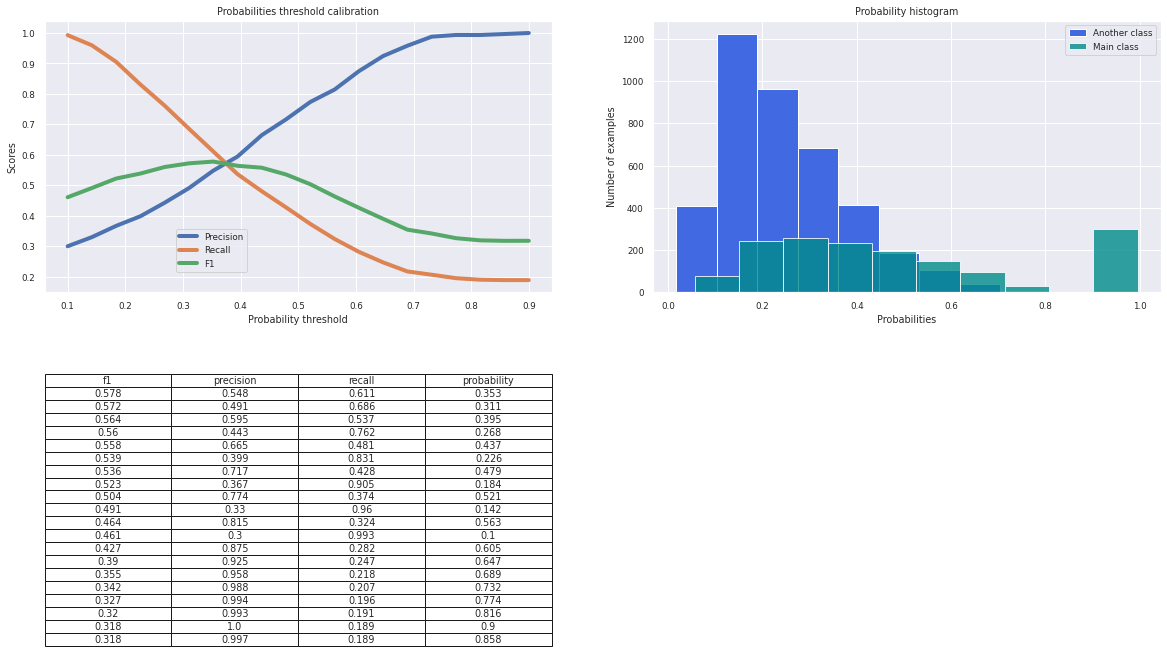

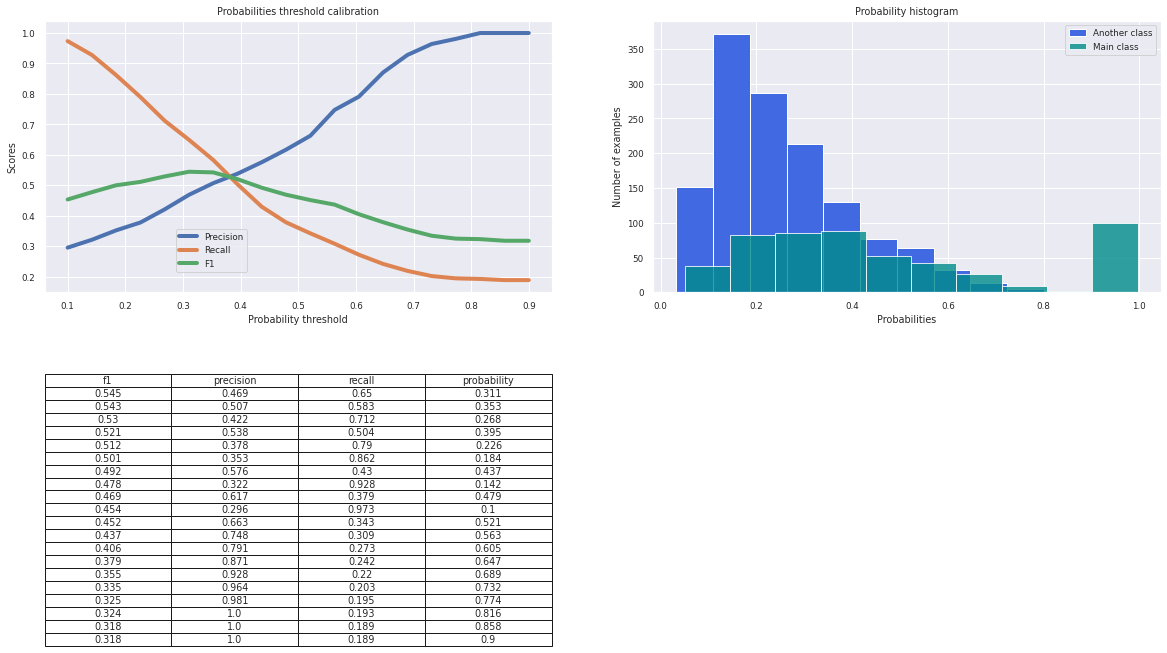

In [78]:
y_train_pred_probs = cb_model.model.predict_proba(cb_model.X_train_full[short_columns])
y_test_pred_probs = cb_model.model.predict_proba(cb_model.X_test[short_columns])
show_proba_calibration_plots(y_train_pred_probs[:, 1], cb_model.y_train_full)
show_proba_calibration_plots(y_test_pred_probs[:, 1], cb_model.y_test)

In [79]:
get_classification_report(cb_model.y_train_full, cb_model.y_train_pred, cb_model.y_test, cb_model.y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      4040
           1       0.50      0.68      0.58      1585

    accuracy                           0.72      5625
   macro avg       0.68      0.71      0.68      5625
weighted avg       0.75      0.72      0.73      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      1347
           1       0.47      0.64      0.54       528

    accuracy                           0.70      1875
   macro avg       0.66      0.68      0.66      1875
weighted avg       0.73      0.70      0.71      1875

CONFUSION MATRIX

col_0           False  True 
Credit Default              
0                 972    375
1                 190    338


### Прогнозирование на тестовом датасете

In [80]:
submit = pd.read_csv('sample_submission.csv')

In [81]:
predictions = cb_model.model.predict_proba(test[short_columns])
predictions = (predictions[:,1] > cb_model.threshold)

In [82]:
predictions = pd.DataFrame(predictions)
predictions = predictions.astype(int)
predictions.iloc[test['Credit Score']==1] = 1
predictions = np.array(predictions[0])

In [83]:
submit['Credit Default'] = predictions
submit.to_csv('submit_rc40.csv', index=False)

In [84]:
end = time.time()
duration = (end - start)/60
duration

0.6963612318038941

In [85]:
datetime.datetime.now()

datetime.datetime(2021, 1, 4, 18, 34, 34, 941418)